
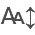

In [41]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import matplotlib.ticker as ticker
from itables import init_notebook_mode
import warnings

warnings.filterwarnings("ignore")
init_notebook_mode(all_interactive=True)
import category_encoders as ce

from sklearn.model_selection import train_test_split
from scipy.stats import uniform, randint

from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    train_test_split,
)


In [3]:
# Configurações para melhorar a visualização dos gráficos
plt.style.use("ggplot")  # Usando um estilo mais genérico
plt.rcParams["figure.figsize"] = (12, 8)

# Configuração adicional para melhorar a legibilidade
sns.set_context("notebook", font_scale=1.2)


In [4]:
def proportions(df, column1, column2):
    out = df.groupby(column1)[column2].value_counts(normalize=True)
    return out.reset_index(name="count")


* dicionário de raça
* N = Não declarado
* P = Preta
* A = Amarela
* I = Indigena
* R = Parda
* B = Branca

# Carrega dados da base pré-processada de cada um dos anos

In [6]:
df_2020_preproc = pd.read_csv("data/df_2020_preproc.csv")
df_2021_preproc = pd.read_csv("data/df_2021_preproc.csv")
df_2022_preproc = pd.read_csv("data/df_2022_preproc.csv")


# Análise exploratória básica

In [68]:
df_2022_preproc.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Data columns (total 57 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   nome                            862 non-null    object 
 1   fase                            862 non-null    int64  
 2   turma                           862 non-null    object 
 3   ano_ingresso                    862 non-null    float64
 4   bolsista                        862 non-null    object 
 5   inde                            862 non-null    float64
 6   cg                              862 non-null    float64
 7   cf                              862 non-null    float64
 8   ct                              862 non-null    float64
 9   pedra                           862 non-null    object 
 10  destaque_ieg                    862 non-null    object 
 11  destaque_ida                    862 non-null    object 
 12  destaque_ipv                    862 

In [5]:
def basic_descriptive_stats(df, column):
    return df[column].describe()


def categorical_descriptive_stats(df, column):
    return df[column].value_counts()


def basic_plots(df):
    out = proportions(df, "sexo", "pedra")

    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 20), constrained_layout=True)

    # Bar plot
    sns.barplot(x=out["sexo"], y=out["count"], hue=out["pedra"], ax=axs[0, 0])
    axs[0, 0].set_xlabel("Sexo")
    axs[0, 0].set_ylabel("Contagem")
    axs[0, 0].set_title("Contagem normalizada por sexo e pedra")

    # KDE plot
    sns.kdeplot(x=df["inde"], hue=df["pedra"], ax=axs[0, 1])
    axs[0, 1].set_xlabel("inde")
    axs[0, 1].set_ylabel("Densidade")
    axs[0, 1].set_title("Distribution do inde por pedra")

    sns.kdeplot(x=df["inde"], hue=df["sexo"], ax=axs[1, 0])
    axs[1, 0].set_xlabel("inde")
    axs[1, 0].set_ylabel("Densidade")
    axs[1, 0].set_title("Distribution do inde por sexo")

    sns.kdeplot(x=df["inde"], hue=df["bolsista_encoded"], ax=axs[1, 1])
    axs[1, 1].set_xlabel("inde")
    axs[1, 1].set_ylabel("Densidade")
    axs[1, 1].set_title("Distribution do inde por bolsista")

    sns.kdeplot(x=df["inde"], hue=df["corraca"], ax=axs[2, 0])
    axs[2, 0].set_xlabel("inde")
    axs[2, 0].set_ylabel("Densidade")
    axs[2, 0].set_title("Distribuição do inde por corraca")

    # Boxplot
    sns.boxplot(
        x=df["pedra"],
        y=df["inde"],
        hue=df["pedra"],
        ax=axs[2, 1],
    )
    axs[2, 1].set_xlabel("Pedra")
    axs[2, 1].set_ylabel("Inde")
    axs[2, 1].set_title("Boxplot do inde por pedra")

    sns.boxplot(
        x=df["pedra"],
        y=df["inde"],
        hue=df["bolsista_encoded"],
        ax=axs[3, 0],
    )
    axs[3, 0].set_xlabel("Pedra")
    axs[3, 0].set_ylabel("Inde")
    axs[3, 0].set_title("Boxplot do inde por bolsista")

    sns.boxplot(
        x=df["pedra"],
        y=df["inde"],
        hue=df["sexo"],
        ax=axs[3, 1],
    )
    axs[3, 1].set_xlabel("Pedra")
    axs[3, 1].set_ylabel("Inde")
    axs[3, 1].set_title("Boxplot do inde por sexo")

    # fig.delaxes(axs[1, 1])
    plt.tight_layout()
    plt.show()


def corr_plot(df):

    corr_cols = [
        "anos_pm",
        "inde",
        "iaa",
        "ieg",
        "ips",
        "ida",
        "ipp",
        "ipv",
        "ian",
        "bolsista_encoded",
        "ponto_virada_encoded",
        "pedra_encoded",
        "na_fase",
        "diff_fase",
        "idade",
        "sexo_encoded",
    ]

    destaque_cols = [
        "destaque_ieg_resultado_encoded",
        "destaque_ida_resultado_encoded",
        "destaque_ipv_resultado_encoded",
    ]

    # Find which destaque_cols are present in df.columns
    existing_destaque_cols = [col for col in destaque_cols if col in df.columns]
    corr_cols.extend(existing_destaque_cols)

    if "rec_sintese" in df.columns:
        corr_cols.append("rec_sintese")

    # Calculando a matriz de correlação
    correlation_matrix = df[corr_cols].corr()

    # Plotando a matriz de correlação como um heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        annot_kws={"size": 8, "rotation": 45},
    )
    plt.title("Heatmap da Matriz de Correlação")
    plt.show()


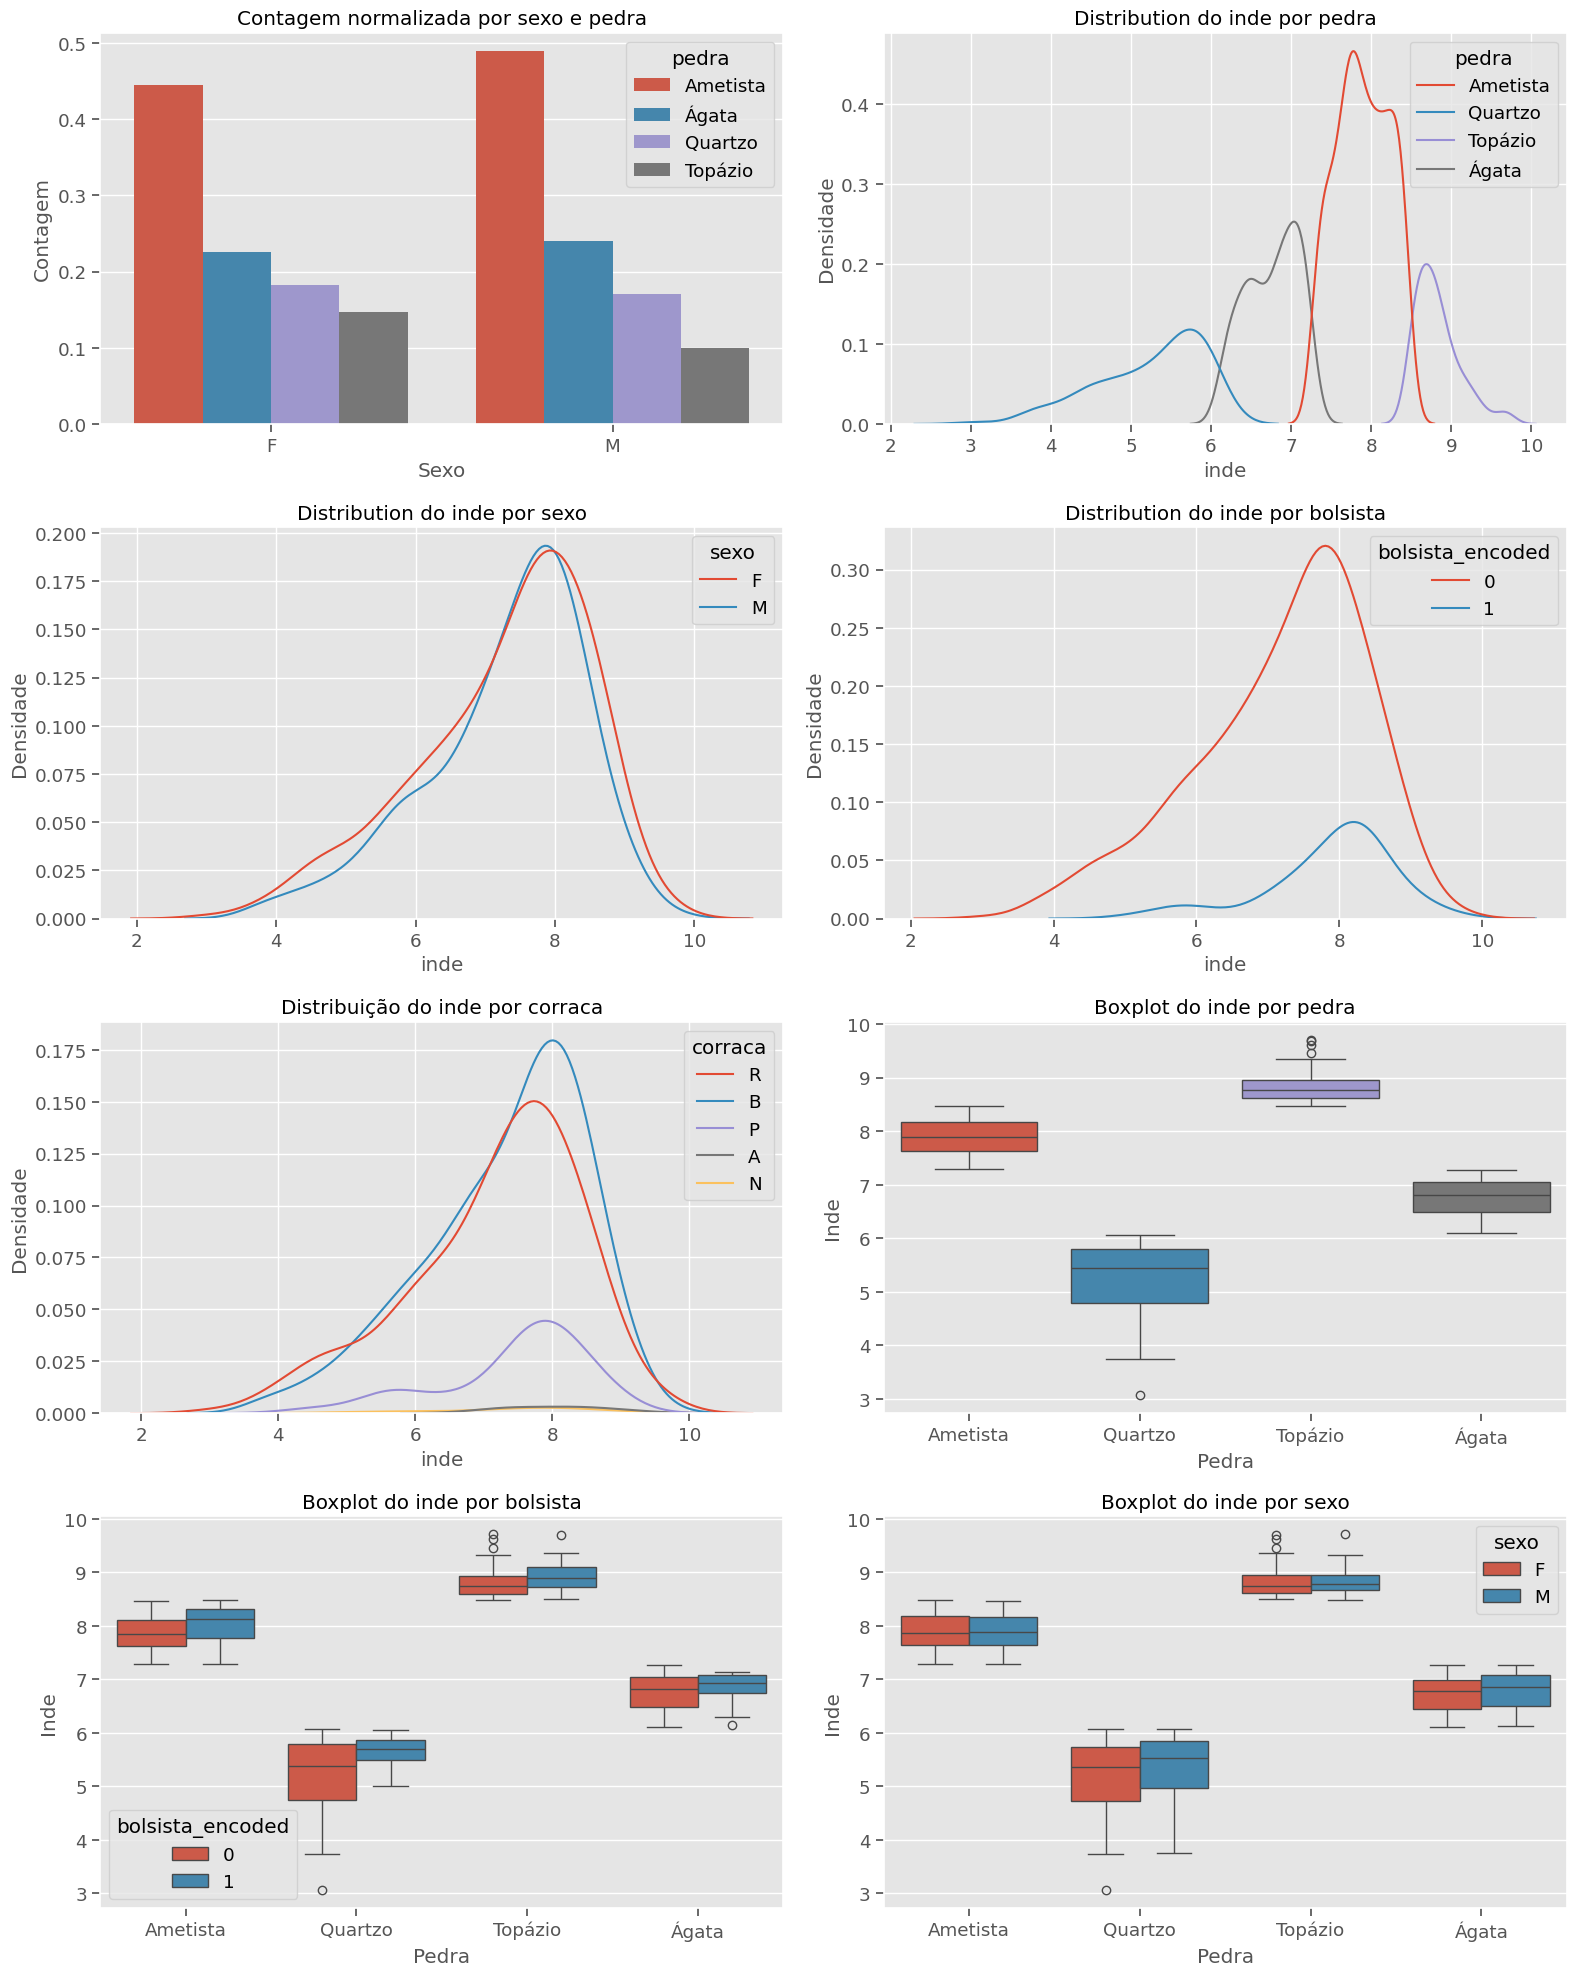

In [42]:
basic_plots(df_2020_preproc)


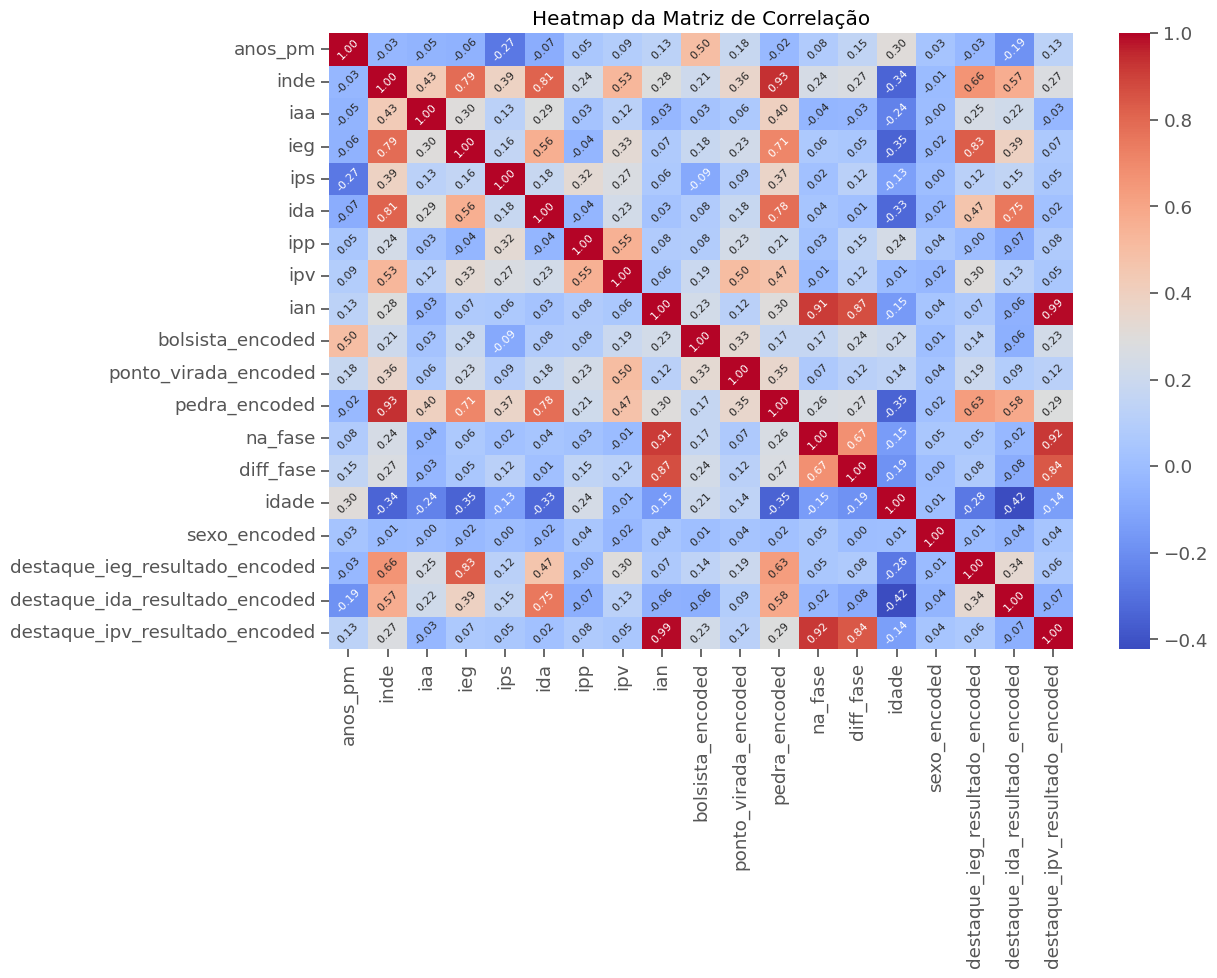

In [63]:
corr_plot(df_2020_preproc)


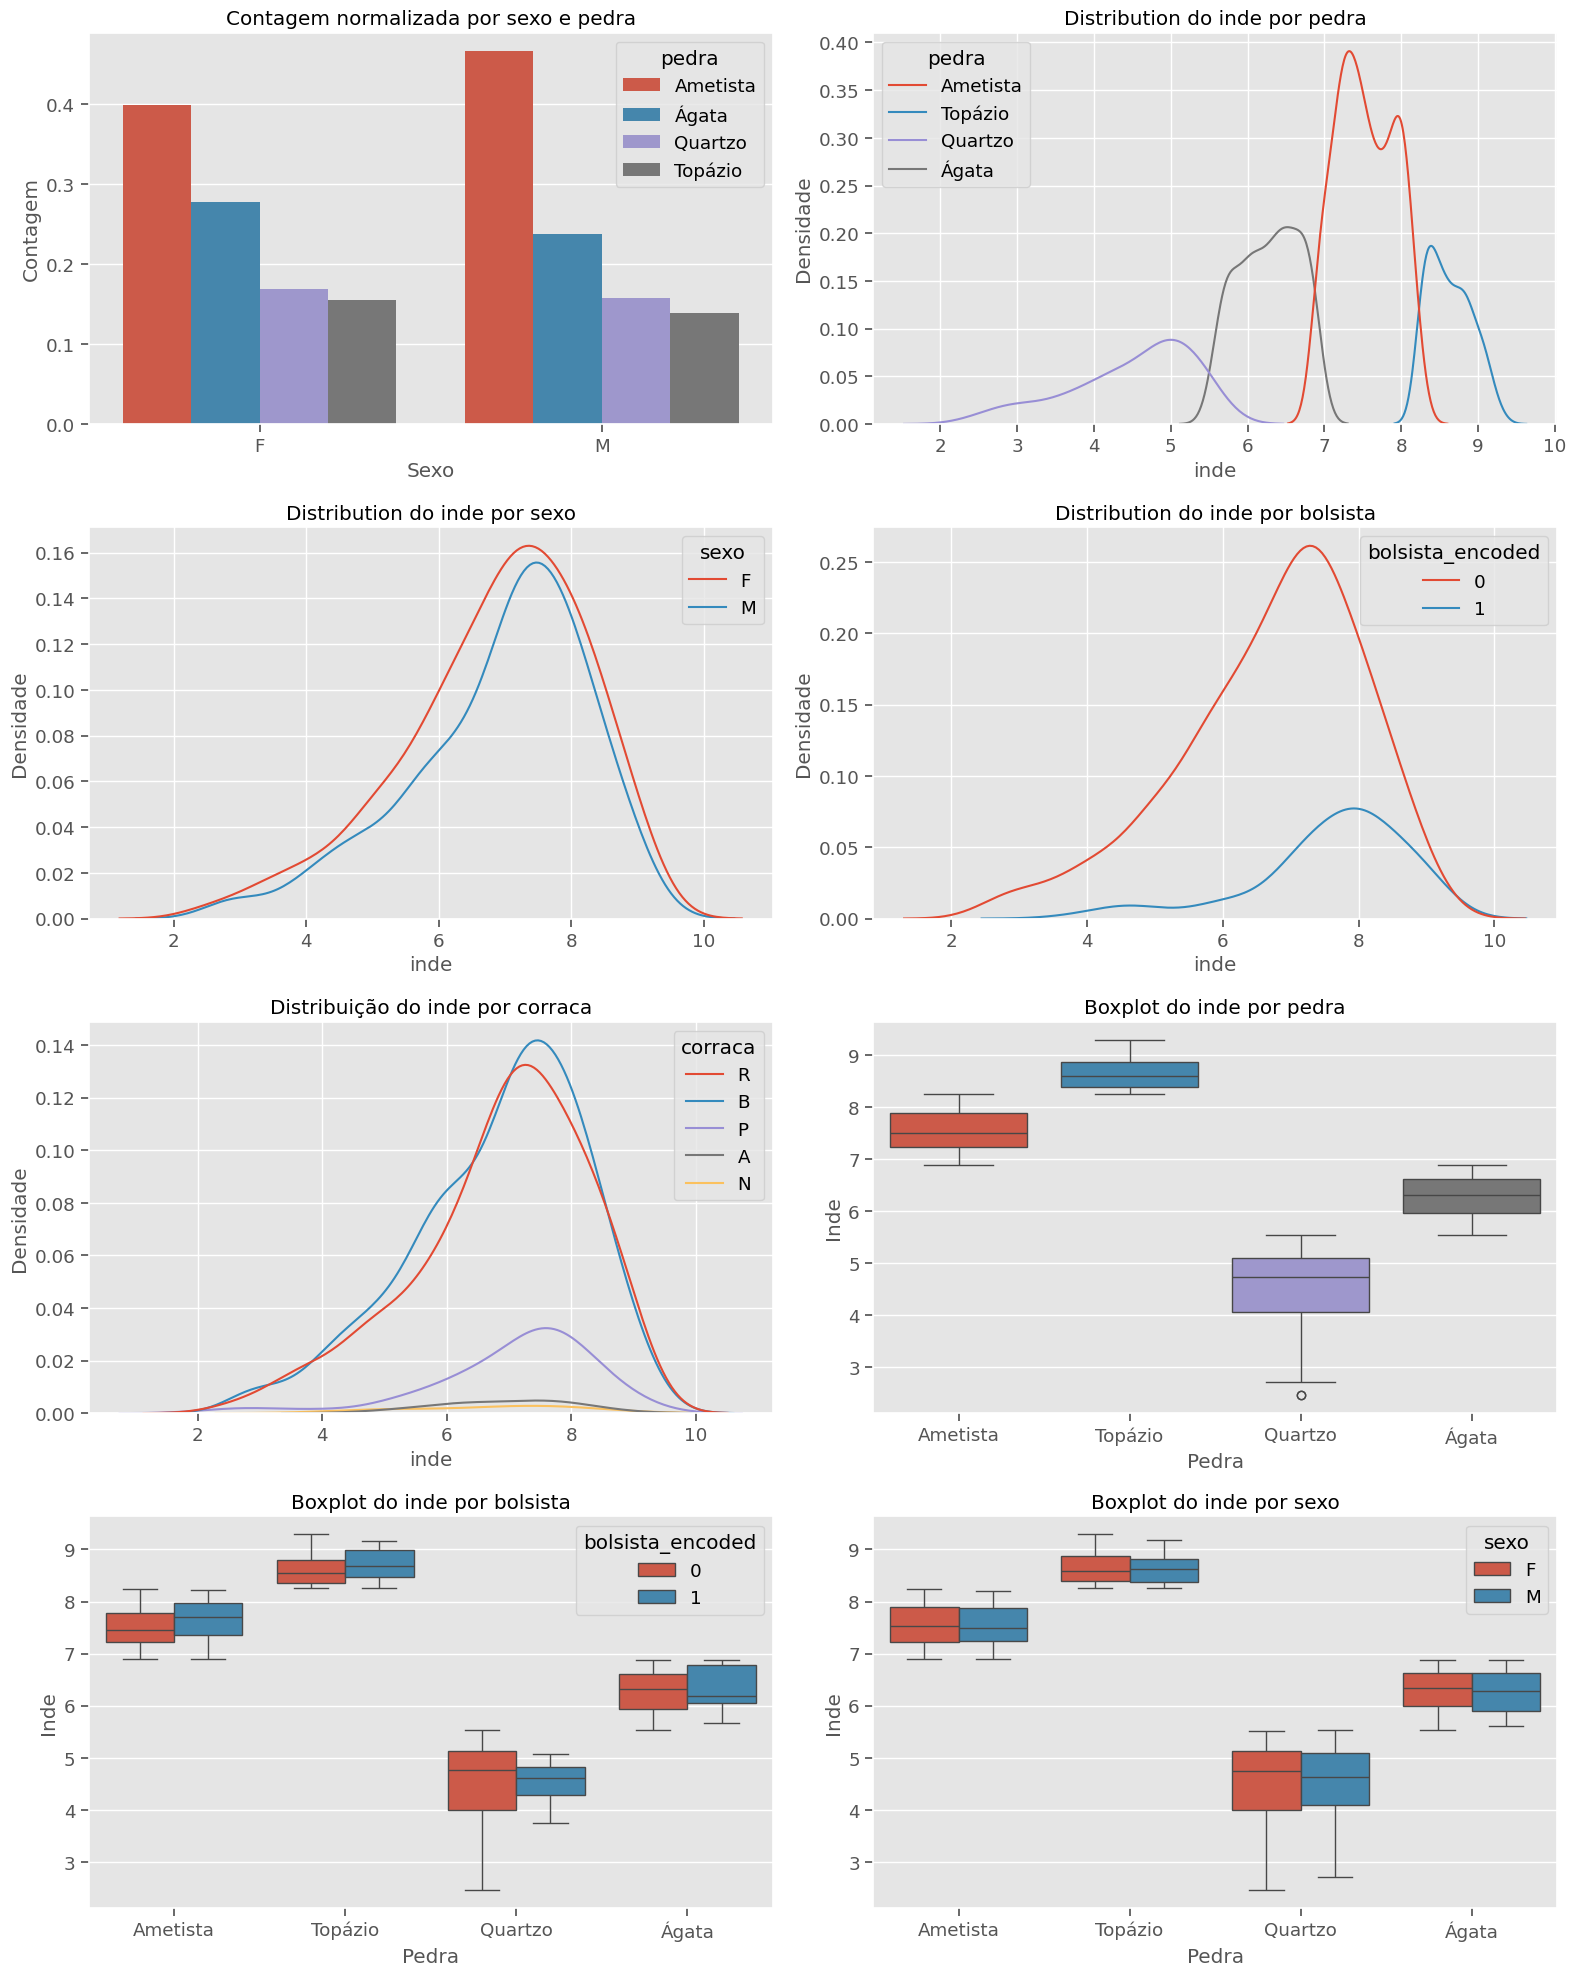

In [43]:
basic_plots(df_2021_preproc)


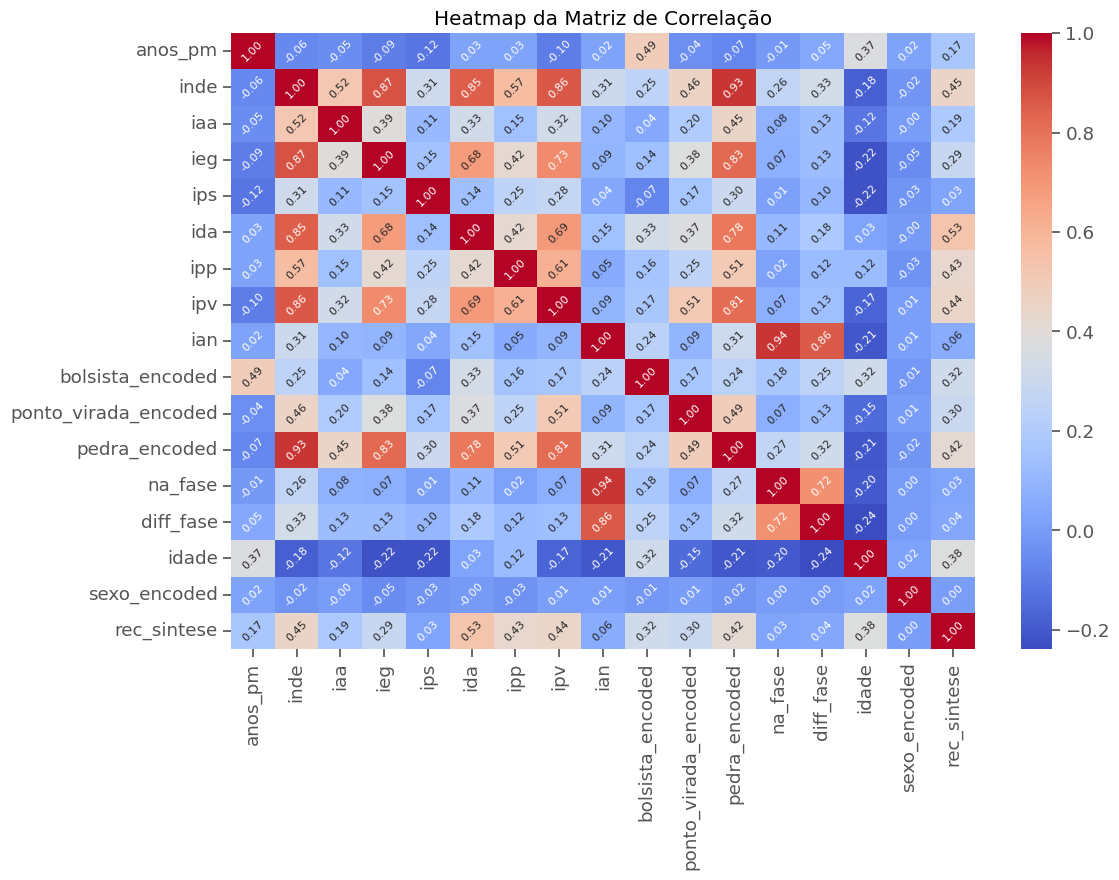

In [65]:
corr_plot(df_2021_preproc)


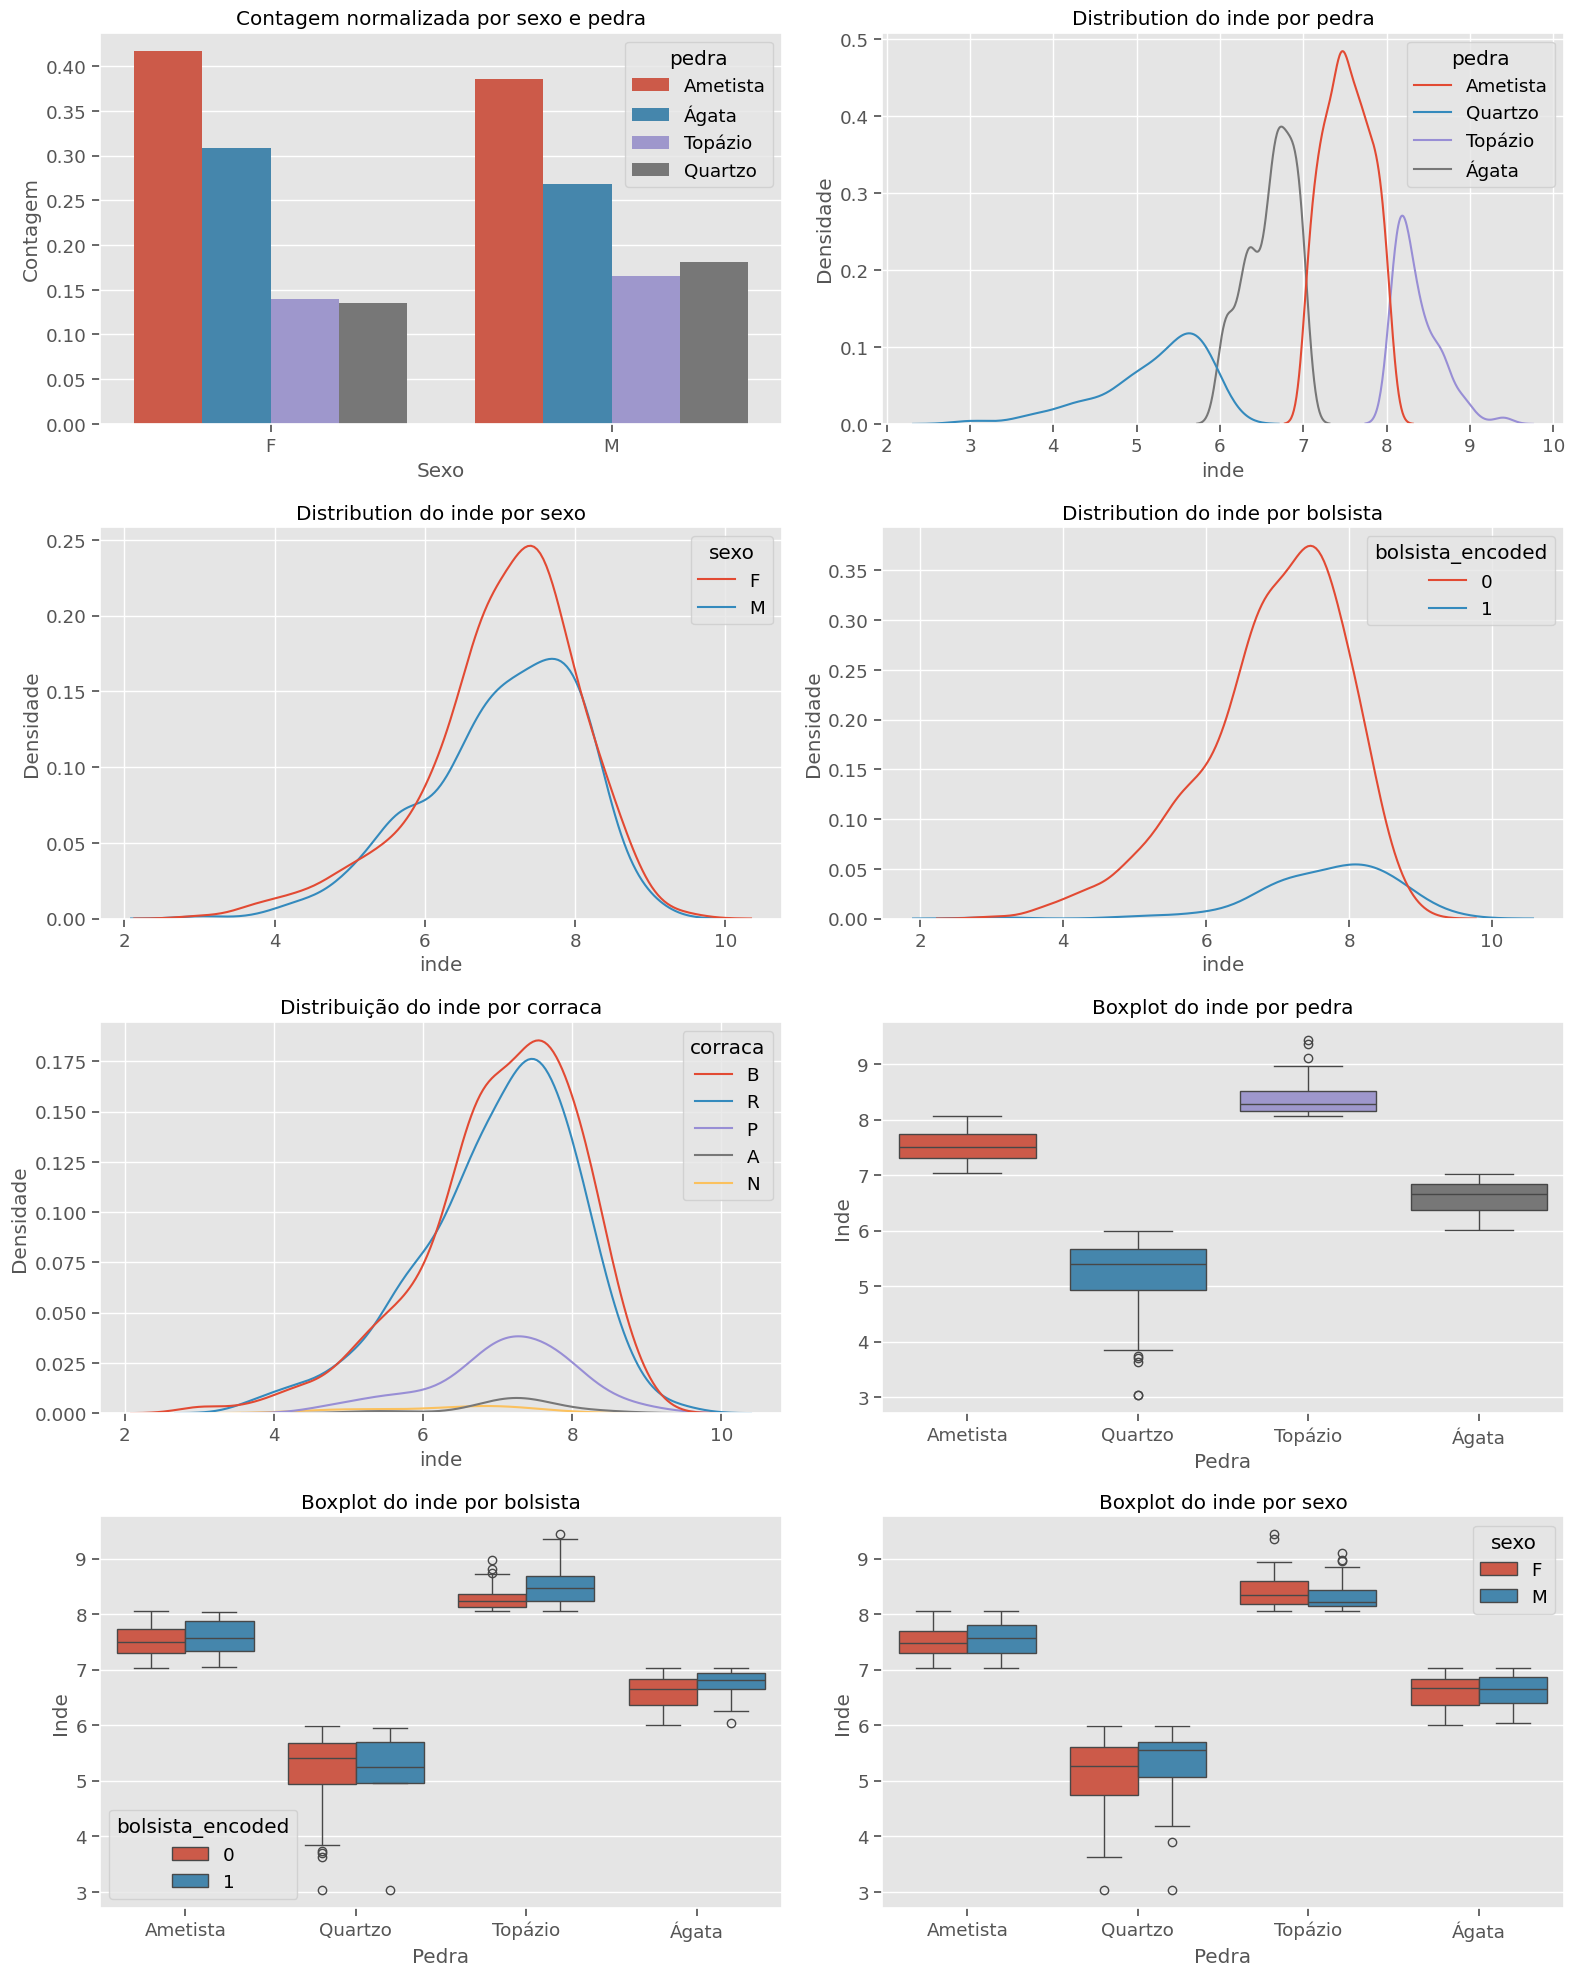

In [44]:
basic_plots(df_2022_preproc)


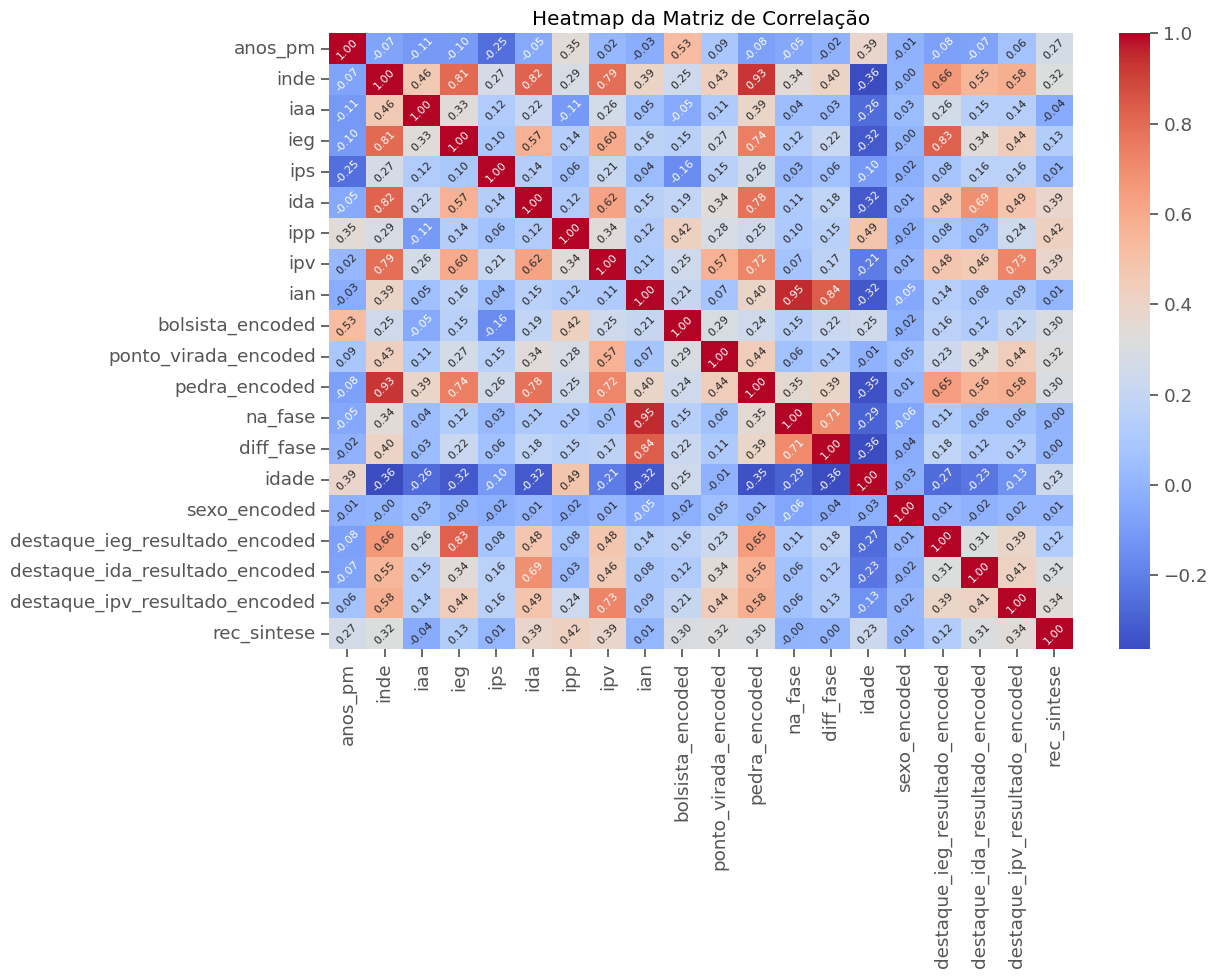

In [66]:
corr_plot(df_2022_preproc)


A contagem dos dados mostra que as classes estão desbalanceadas ou ainda contêm valores sem sentido. 

df_complete.iloc[69]

#### Visão dos dados até o momento

Existe uma quantidade substancial de dados ausentes `NA` (e também `"ND"`) em todas as colunas:

Existe uma quantidade substancial de dados ausentes `NA` (e também `"ND"`) em todas as colunas

## Visão geral de alguns indicadores ao longo dos anos (por sexo)

In [69]:
df_complete = pd.read_csv("data/df_pooled_common.csv")


In [180]:
# funções auxiliares
def teste_t(df, indicador, categoria):
    from itertools import permutations

    categorias = permutations(df[categoria].unique().dropna(), 2)

    for i in categorias:
        categoria_i = df[df[categoria] == i[0]][indicador]
        categoria_j = df[df[categoria] == i[1]][indicador]

        t_stat, p_value = stats.ttest_ind(categoria_i, categoria_j)

        if p_value <= 0.05:
            print(f"Resultado do teste t para:")
            print(f"t-statistic: {t_stat:.2f}")
            print(f"p-value: {p_value:.4f}")
            print(f"Categorias:{i} => Diferença é estatisticamente significativa.\n")


## INDE - por ano e por gênero

Text(0.5, 1.0, 'Distribuição do INDE por ano e por sexo')

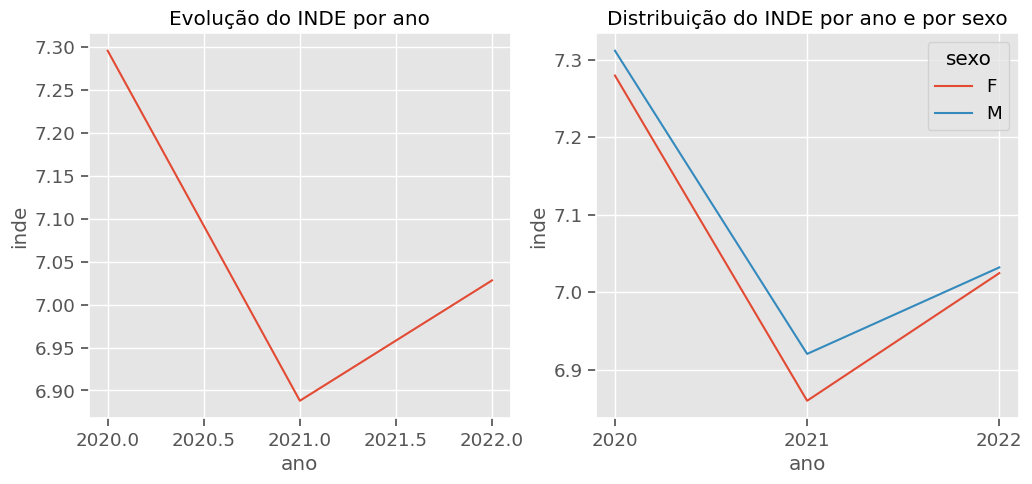

In [181]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 linha, 2 colunas

inde_by_year = df_complete.groupby("ano")["inde"].mean().reset_index()
inde_by_year_gender = df_complete.groupby(["ano", "sexo"])["inde"].mean().reset_index()
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

sns.lineplot(data=inde_by_year, x="ano", y="inde", ax=axes[0])
axes[0].set_title("Evolução do INDE por ano")

sns.lineplot(data=inde_by_year_gender, x="ano", y="inde", hue="sexo", ax=axes[1])
axes[1].set_title("Distribuição do INDE por ano e por sexo")


### Verifica a normalidade dos dados

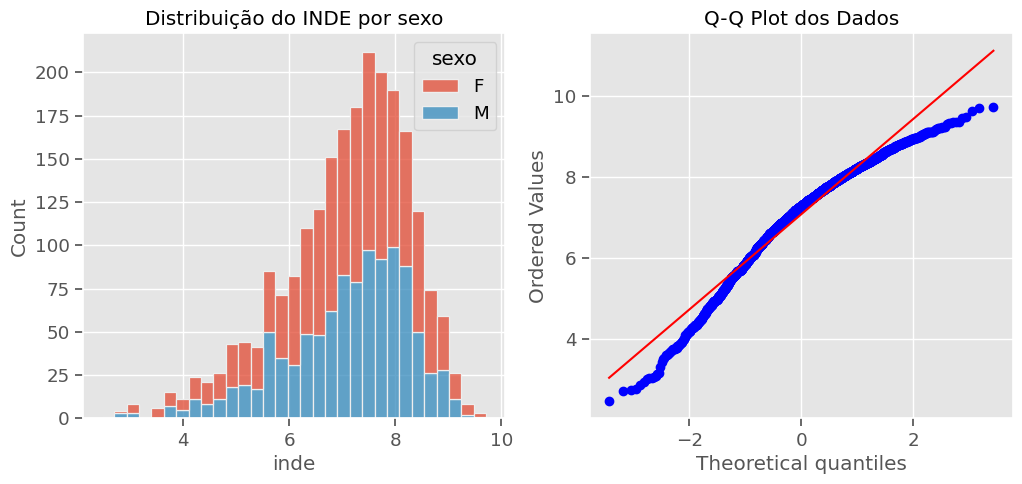

In [182]:
# Verifica a normalidade dos dados

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 linha, 2 colunas

# Gráfico com seaborn
sns.histplot(data=df_complete, x="inde", hue="sexo", multiple="stack", ax=axes[0])
axes[0].set_title("Distribuição do INDE por sexo")

# Gráfico com matplotlib
plt.sca(axes[1])
stats.probplot(df_complete["inde"], dist="norm", plot=plt)
axes[1].set_title("Q-Q Plot dos Dados")

# Mostrar a figura
plt.show()


#### Teste Mann-Whitney U 

 Comparar dois grupos (neste caso, sexo masculino e feminino) quando os dados não seguem uma distribuição normal.

In [183]:
import scipy.stats as stats

# Separando os dados por sexo
male_inde = df_complete[df_complete["sexo"] == "M"]["inde"]
female_inde = df_complete[df_complete["sexo"] == "F"]["inde"]

# Realizando o teste de Mann-Whitney U
u_statistic, p_value = stats.mannwhitneyu(male_inde, female_inde)

print(f"U-Statistic: {u_statistic}, p-value: {p_value}")


U-Statistic: 650862.0, p-value: 0.44218238406237553


Interpretação: Se o valor p (p_value) for menor que um nível de significância (comum é 0,05), você pode rejeitar a hipótese nula e concluir que existe uma diferença estatisticamente significativa entre os valores de inde para os diferentes sexos.


#### Teste de Kruskal-Wallis

 Comparar mais de dois grupos (neste caso, os anos de 2020, 2021 e 2022) quando os dados não seguem uma distribuição normal.

In [184]:
# Separando os dados por ano
inde_2020 = df_complete[df_complete["ano"] == 2020]["inde"]
inde_2021 = df_complete[df_complete["ano"] == 2021]["inde"]
inde_2022 = df_complete[df_complete["ano"] == 2022]["inde"]

# Realizando o teste de Kruskal-Wallis
h_statistic, p_value = stats.kruskal(inde_2020, inde_2021, inde_2022)

print(f"H-Statistic: {h_statistic}, p-value: {p_value}")


H-Statistic: 47.25395906912189, p-value: 5.48192594138268e-11


Interpretação: Assim como no teste anterior, se o valor p (p_value) for menor que o nível de significância (geralmente 0,05), você pode concluir que existe uma diferença estatisticamente significativa entre os anos analisados.

#### Teste de Dunn

Se o teste de Kruskal-Wallis indicar uma diferença significativa, você pode querer identificar especificamente quais pares de anos diferem. Para isso, você pode usar o Teste de Dunn com correção de Bonferroni para múltiplas comparações.

In [185]:
import scikit_posthocs as sp

# Realizando o teste de Dunn
dunn_result = sp.posthoc_dunn([inde_2020, inde_2021, inde_2022], p_adjust="bonferroni")

print(dunn_result)


              1             2             3
1  1.000000e+00  2.597729e-09  1.858829e-08
2  2.597729e-09  1.000000e+00  1.000000e+00
3  1.858829e-08  1.000000e+00  1.000000e+00


Interpretação: A matriz resultante mostrará os valores p para cada par de comparações. Se um valor p for menor que 0,05 após a correção de Bonferroni, esse par de anos tem uma diferença significativa no indicador inde.

#### Teste Mann-Whitney U 

Comparação entre genêros para cada ano


In [186]:
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 1. Comparação entre sexos para cada ano
years = [2020, 2021, 2022]

for year in years:
    male_data = df_complete[
        (df_complete["ano"] == year) & (df_complete["sexo"] == "M")
    ]["inde"]
    female_data = df_complete[
        (df_complete["ano"] == year) & (df_complete["sexo"] == "F")
    ]["inde"]

    statistic, p_value = stats.mannwhitneyu(
        male_data, female_data, alternative="two-sided"
    )

    print(f"Ano {year}:")
    print(f"Estatística do teste Mann-Whitney U: {statistic}")
    print(f"Valor p: {p_value}")
    print(
        "Diferença estatisticamente significativa"
        if p_value < 0.05
        else "Diferença não significativa"
    )
    print()


Ano 2020:
Estatística do teste Mann-Whitney U: 65534.0
Valor p: 0.9633813747188757
Diferença não significativa

Ano 2021:
Estatística do teste Mann-Whitney U: 59497.0
Valor p: 0.5124840792362517
Diferença não significativa

Ano 2022:
Estatística do teste Mann-Whitney U: 92481.0
Valor p: 0.7740545930259126
Diferença não significativa



Interpretação do p-valor
p-valor alto (geralmente > 0,05):

Interpretação: Você não rejeita a hipótese nula. Isso sugere que não há evidências suficientes para concluir que os dados não seguem uma distribuição normal. Em outras palavras, os dados podem ser considerados normalmente distribuídos.
Exemplo: Se o p-valor é 0,12, você não rejeita a hipótese nula e pode supor que os dados seguem uma distribuição normal.
p-valor baixo (geralmente ≤ 0,05):

Interpretação: Você rejeita a hipótese nula. Isso sugere que há evidências suficientes para concluir que os dados não seguem uma distribuição normal. Portanto, os dados não são normalmente distribuídos.
Exemplo: Se o p-valor é 0,03, você rejeita a hipótese nula e conclui que os dados provavelmente não seguem uma distribuição normal.

#### Conclusão dos testes

- Não existe diferença estatisticamente significativa no INDE de acordo com o gênero dos alunos, tanto no agregado, quanto entre os anos;
- Existe diferença estatisticamente significativa no INDE quando se compara 2020 com 2021 ou 2022, porém não há diferença estatisticamente significativa entre 2021 e 2022

## Pedras

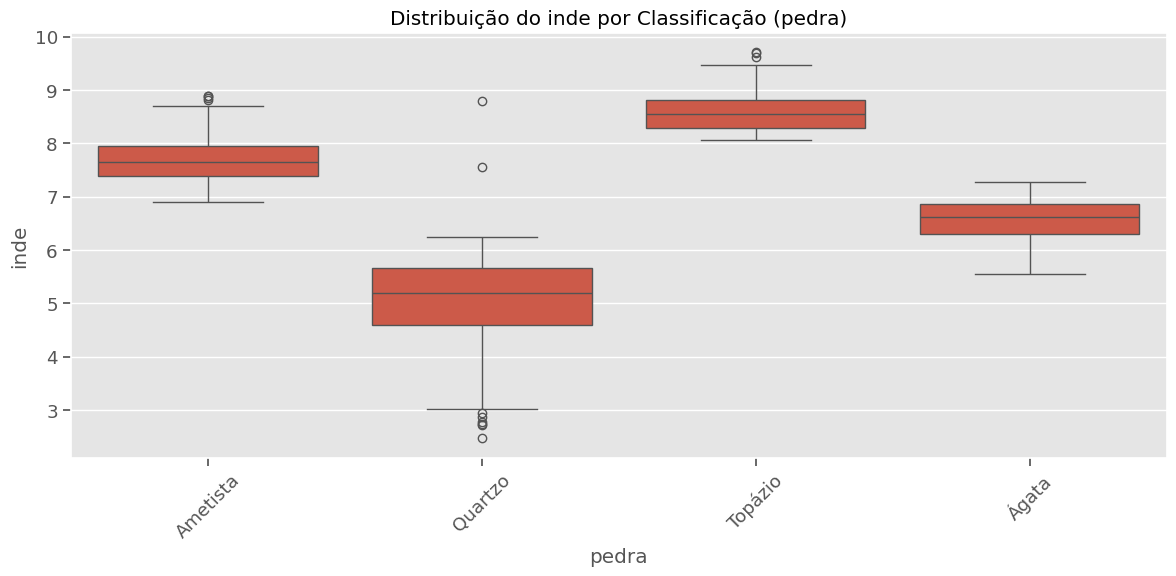

In [187]:
# Criando o boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="pedra", y="inde", data=df_complete)
plt.title("Distribuição do inde por Classificação (pedra)")
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhor legibilidade
plt.tight_layout()  # Ajusta o layout para evitar cortes nos rótulos
plt.show()


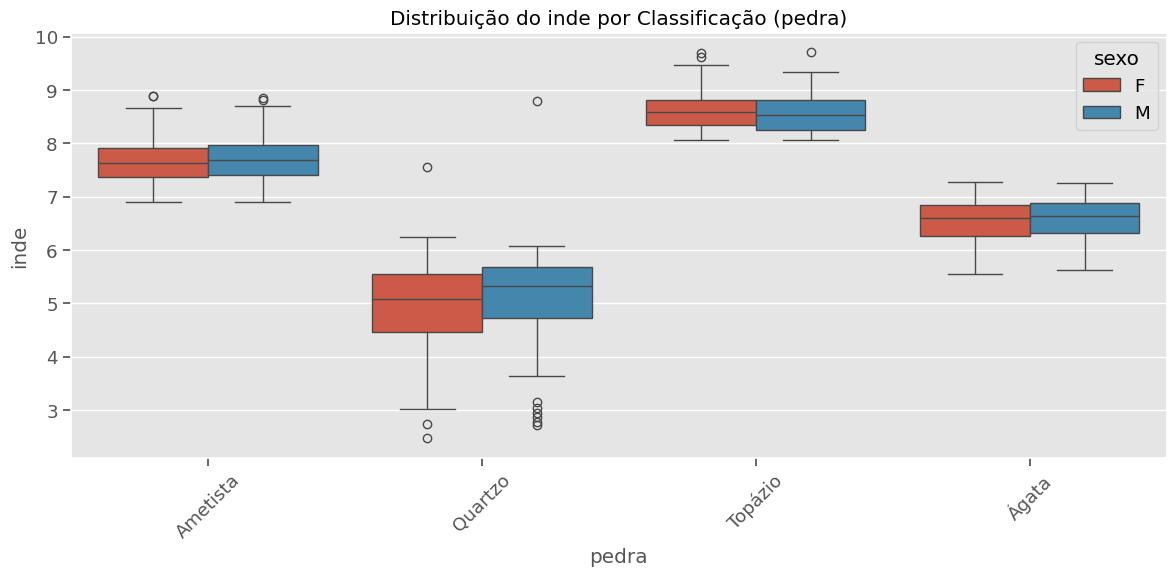

In [188]:
# Criando o boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="pedra", y="inde", data=df_complete, hue="sexo")
plt.title("Distribuição do inde por Classificação (pedra)")
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhor legibilidade
plt.tight_layout()  # Ajusta o layout para evitar cortes nos rótulos
plt.show()


### Todos os indicadores numéricos

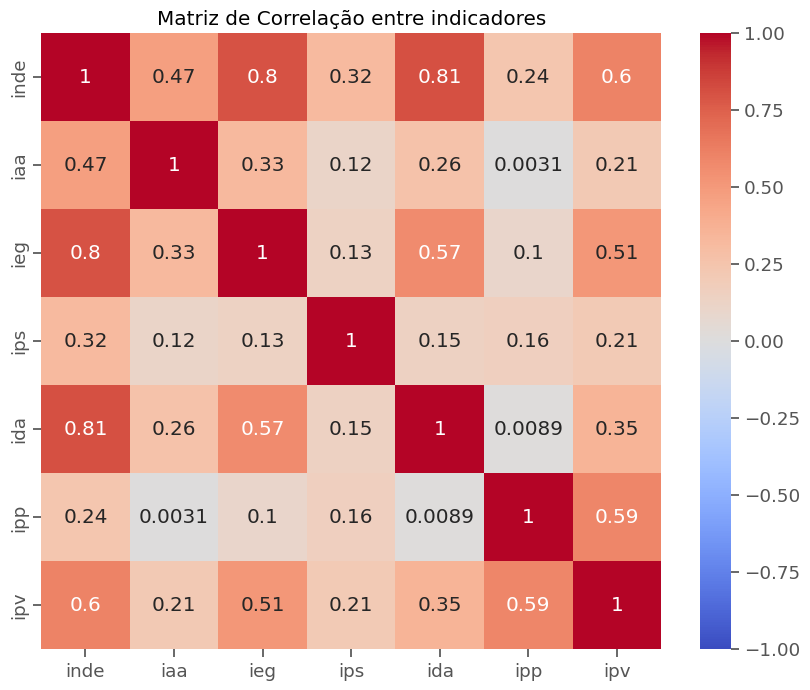

In [189]:
# Heatmap de correlação entre variáveis numéricas
numeric_vars = ["inde", "iaa", "ieg", "ips", "ida", "ipp", "ipv"]
corr_matrix = df_complete[numeric_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Matriz de Correlação entre indicadores")
plt.show()


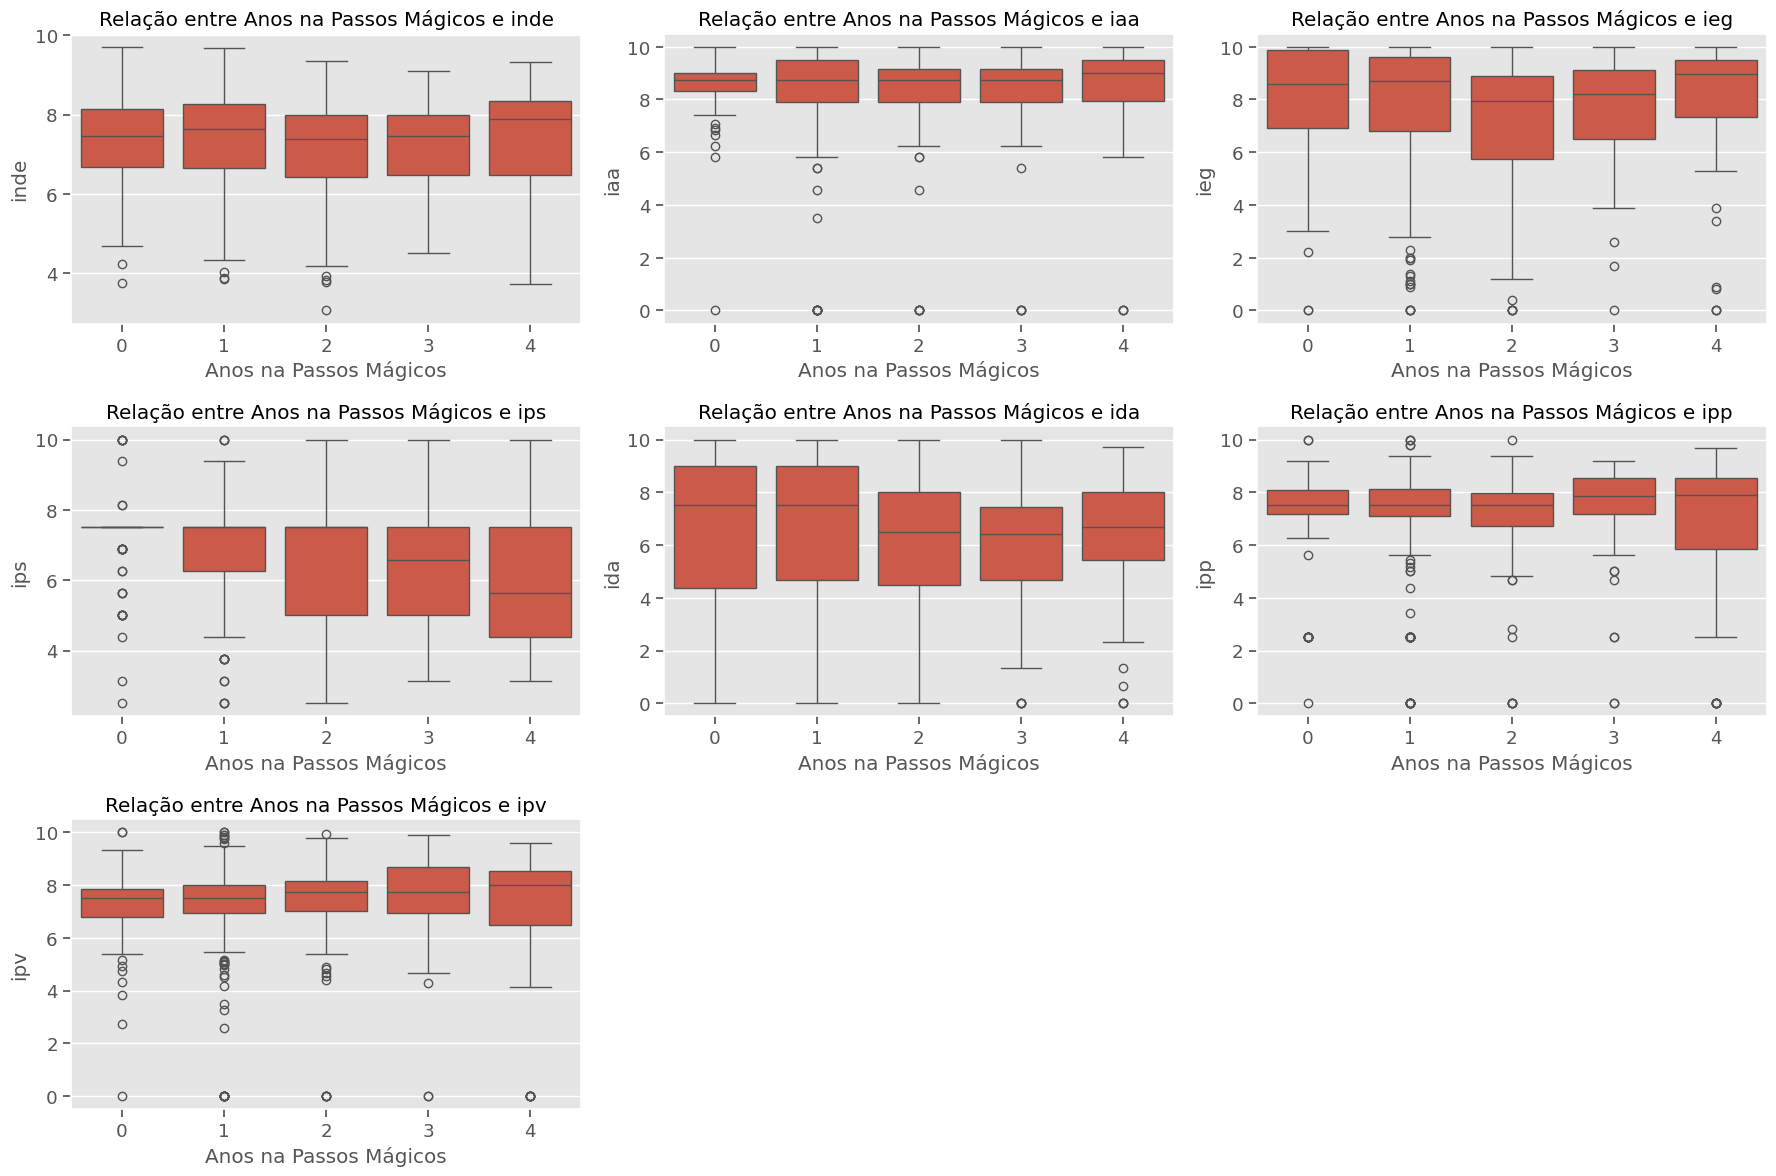

In [190]:
# plot the boxplot for each indicator and anos_pm side by side
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))

for i, ax in enumerate(axes.flat):
    if i < len(numeric_vars):
        sns.boxplot(x="anos_pm", y=numeric_vars[i], data=df_complete, ax=ax)
        ax.set_title(f"Relação entre Anos na Passos Mágicos e {numeric_vars[i]}")
        ax.set_xlabel("Anos na Passos Mágicos")
        ax.set_ylabel(numeric_vars[i])
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()


In [191]:
# Testar a normalidade dos indicadores
normality_results = []

for var in numeric_vars:
    # Realizar o teste de Shapiro-Wilk
    statistic, p_value = stats.shapiro(df_complete[var].dropna())

    # Armazenar os resultados
    normality_results.append(
        {
            "Variable": var,
            "Statistic": statistic,
            "P-value": p_value,
            "Is Normal": p_value > 0.05,
        }
    )

# Criar um DataFrame com os resultados
normality_df = pd.DataFrame(normality_results)

# Formatar o DataFrame para exibição
normality_df["Statistic"] = normality_df["Statistic"].round(4)
normality_df["P-value"] = normality_df["P-value"].round(4)

# Exibir o DataFrame
display(
    normality_df.style.set_caption("Teste de Normalidade (Shapiro-Wilk)")
    .applymap(
        lambda x: (
            "background-color: lightgreen" if x else "background-color: lightsalmon"
        ),
        subset=["Is Normal"],
    )
    .set_properties(**{"text-align": "center"})
    .set_table_styles([{"selector": "th", "props": [("text-align", "center")]}])
)


In [192]:
# Os dados não são normalmente distribuídos, então:
# Perform Mann-Whitney U test for each year against the list numeric_vars
years = df_complete["ano"].unique()
results = {}

for year in years:
    year_data = df_complete[df_complete["ano"] == year]
    other_years_data = df_complete[df_complete["ano"] != year]

    year_results = {}
    for var in numeric_vars:
        statistic, p_value = stats.mannwhitneyu(
            year_data[var].dropna(),
            other_years_data[var].dropna(),
            alternative="two-sided",
        )
        year_results[var] = {"statistic": statistic, "p_value": p_value}

    results[year] = year_results

# Create a DataFrame with the results
results_df = pd.DataFrame(
    columns=["Year", "Variable", "Statistic", "P-value", "Significant"]
)

for year, year_results in results.items():
    for var, test_results in year_results.items():
        new_row = pd.DataFrame(
            {
                "Year": [year],
                "Variable": [var],
                "Statistic": [f"{test_results['statistic']:.4f}"],
                "P-value": [f"{test_results['p_value']:.4f}"],
                "Significant": ["Yes" if test_results["p_value"] < 0.05 else "No"],
            }
        )
        results_df = pd.concat([results_df, new_row], ignore_index=True)


# Sort the DataFrame by Year and Variable
results_df = results_df.sort_values(["Year", "Variable"])

# Display the results as a beautiful table
from IPython.display import display, HTML


def highlight_significant(val):
    return "background-color: green" if val == "Yes" else ""


styled_df = results_df.style.applymap(highlight_significant, subset=["Significant"])
styled_df = styled_df.set_properties(**{"text-align": "center"})
styled_df = styled_df.set_table_styles(
    [
        {
            "selector": "th",
            "props": [
                ("background-color", "#f2f2f2"),
                ("font-weight", "bold"),
                ("text-align", "center"),
            ],
        },
        {"selector": "td", "props": [("padding", "8px")]},
        {
            "selector": "",
            "props": [("border-collapse", "collapse"), ("border", "1px solid #ddd")],
        },
    ]
)

display(HTML(styled_df.to_html()))


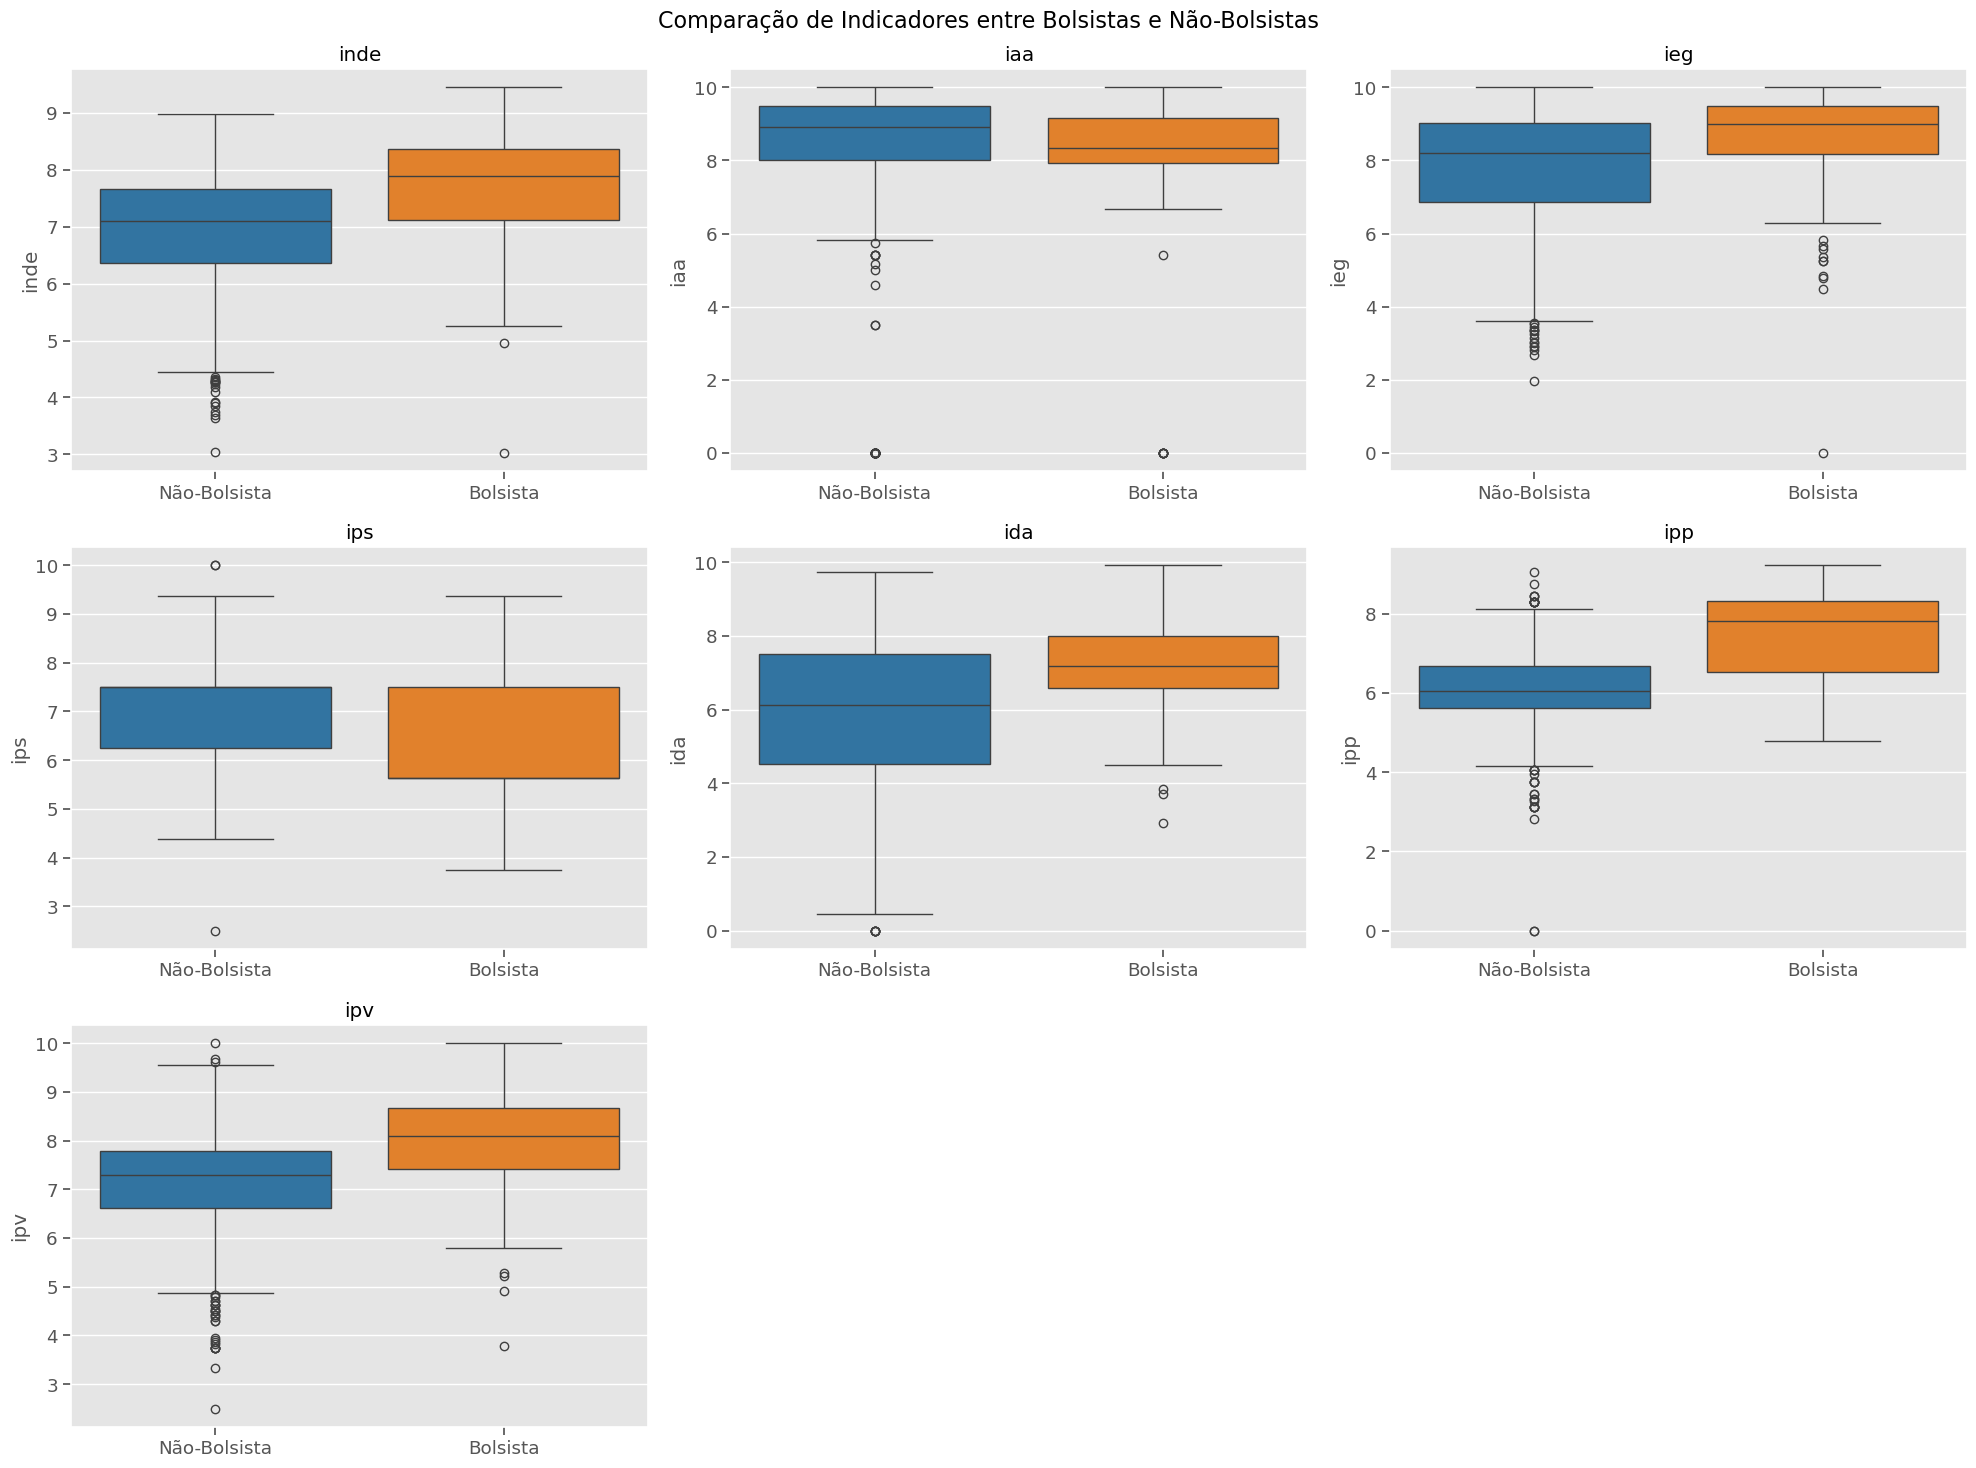

In [193]:
import warnings

warnings.filterwarnings("ignore")

# Filter numeric variables that are present in df_complete
numeric_vars_filtered = [var for var in numeric_vars if var in df_complete.columns]

# Calculate the number of rows and columns for the grid
n_vars = len(numeric_vars_filtered)
n_cols = 3  # You can adjust this to change the number of columns in the grid
n_rows = (n_vars + n_cols - 1) // n_cols

# Create the grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
fig.suptitle("Comparação de Indicadores entre Bolsistas e Não-Bolsistas", fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Define colors for each category
colors = ["#1f77b4", "#ff7f0e"]  # Blue for Não-Bolsista, Orange for Bolsista


# Create boxplots for each variable
for i, var in enumerate(numeric_vars_filtered):
    sns.boxplot(
        x="categoria_bolsista", y=var, data=df_complete, ax=axes[i], palette=colors
    )
    axes[i].set_title(var)
    axes[i].set_xlabel("")
    axes[i].set_xticklabels(["Não-Bolsista", "Bolsista"])

# Remove any unused subplots
for i in range(n_vars, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [194]:
# Lista de indicadores para análise
indicadores = ["inde", "iaa", "ieg", "ips", "ida", "ipp", "ipv"]

# Dicionário para armazenar os resultados
resultados = {}

for indicador in indicadores:
    bolsistas = df_complete[df_complete["bolsista"] == 1][indicador].dropna()
    nao_bolsistas = df_complete[df_complete["bolsista"] == 0][indicador].dropna()

    # Aplicando o teste de Mann-Whitney U
    statistic, p_value = stats.mannwhitneyu(
        bolsistas, nao_bolsistas, alternative="two-sided"
    )

    resultados[indicador] = {
        "estatistica": statistic,
        "p_valor": p_value,
        "significativo": p_value < 0.05,
    }


# Criando um DataFrame com os resultados para melhor visualização
df_resultados = pd.DataFrame.from_dict(resultados, orient="index")
df_resultados["Indicador"] = df_resultados.index
df_resultados = df_resultados.rename(
    columns={
        "estatistica": "Estatística U",
        "p_valor": "p-valor",
        "significativo": "Diferença Significativa",
    }
)
df_resultados = df_resultados[
    ["Indicador", "Estatística U", "p-valor", "Diferença Significativa"]
]

# Exibindo o DataFrame de resultados
display(df_resultados.style.format({"Estatística U": "{:.4f}", "p-valor": "{:.4f}"}))


p < 0.05: "Há uma diferença estatisticamente significativa no INDE entre bolsistas e não bolsistas. Com base na estatística t (positiva), podemos concluir que os bolsistas têm um INDE médio significativamente maior que os não bolsistas."

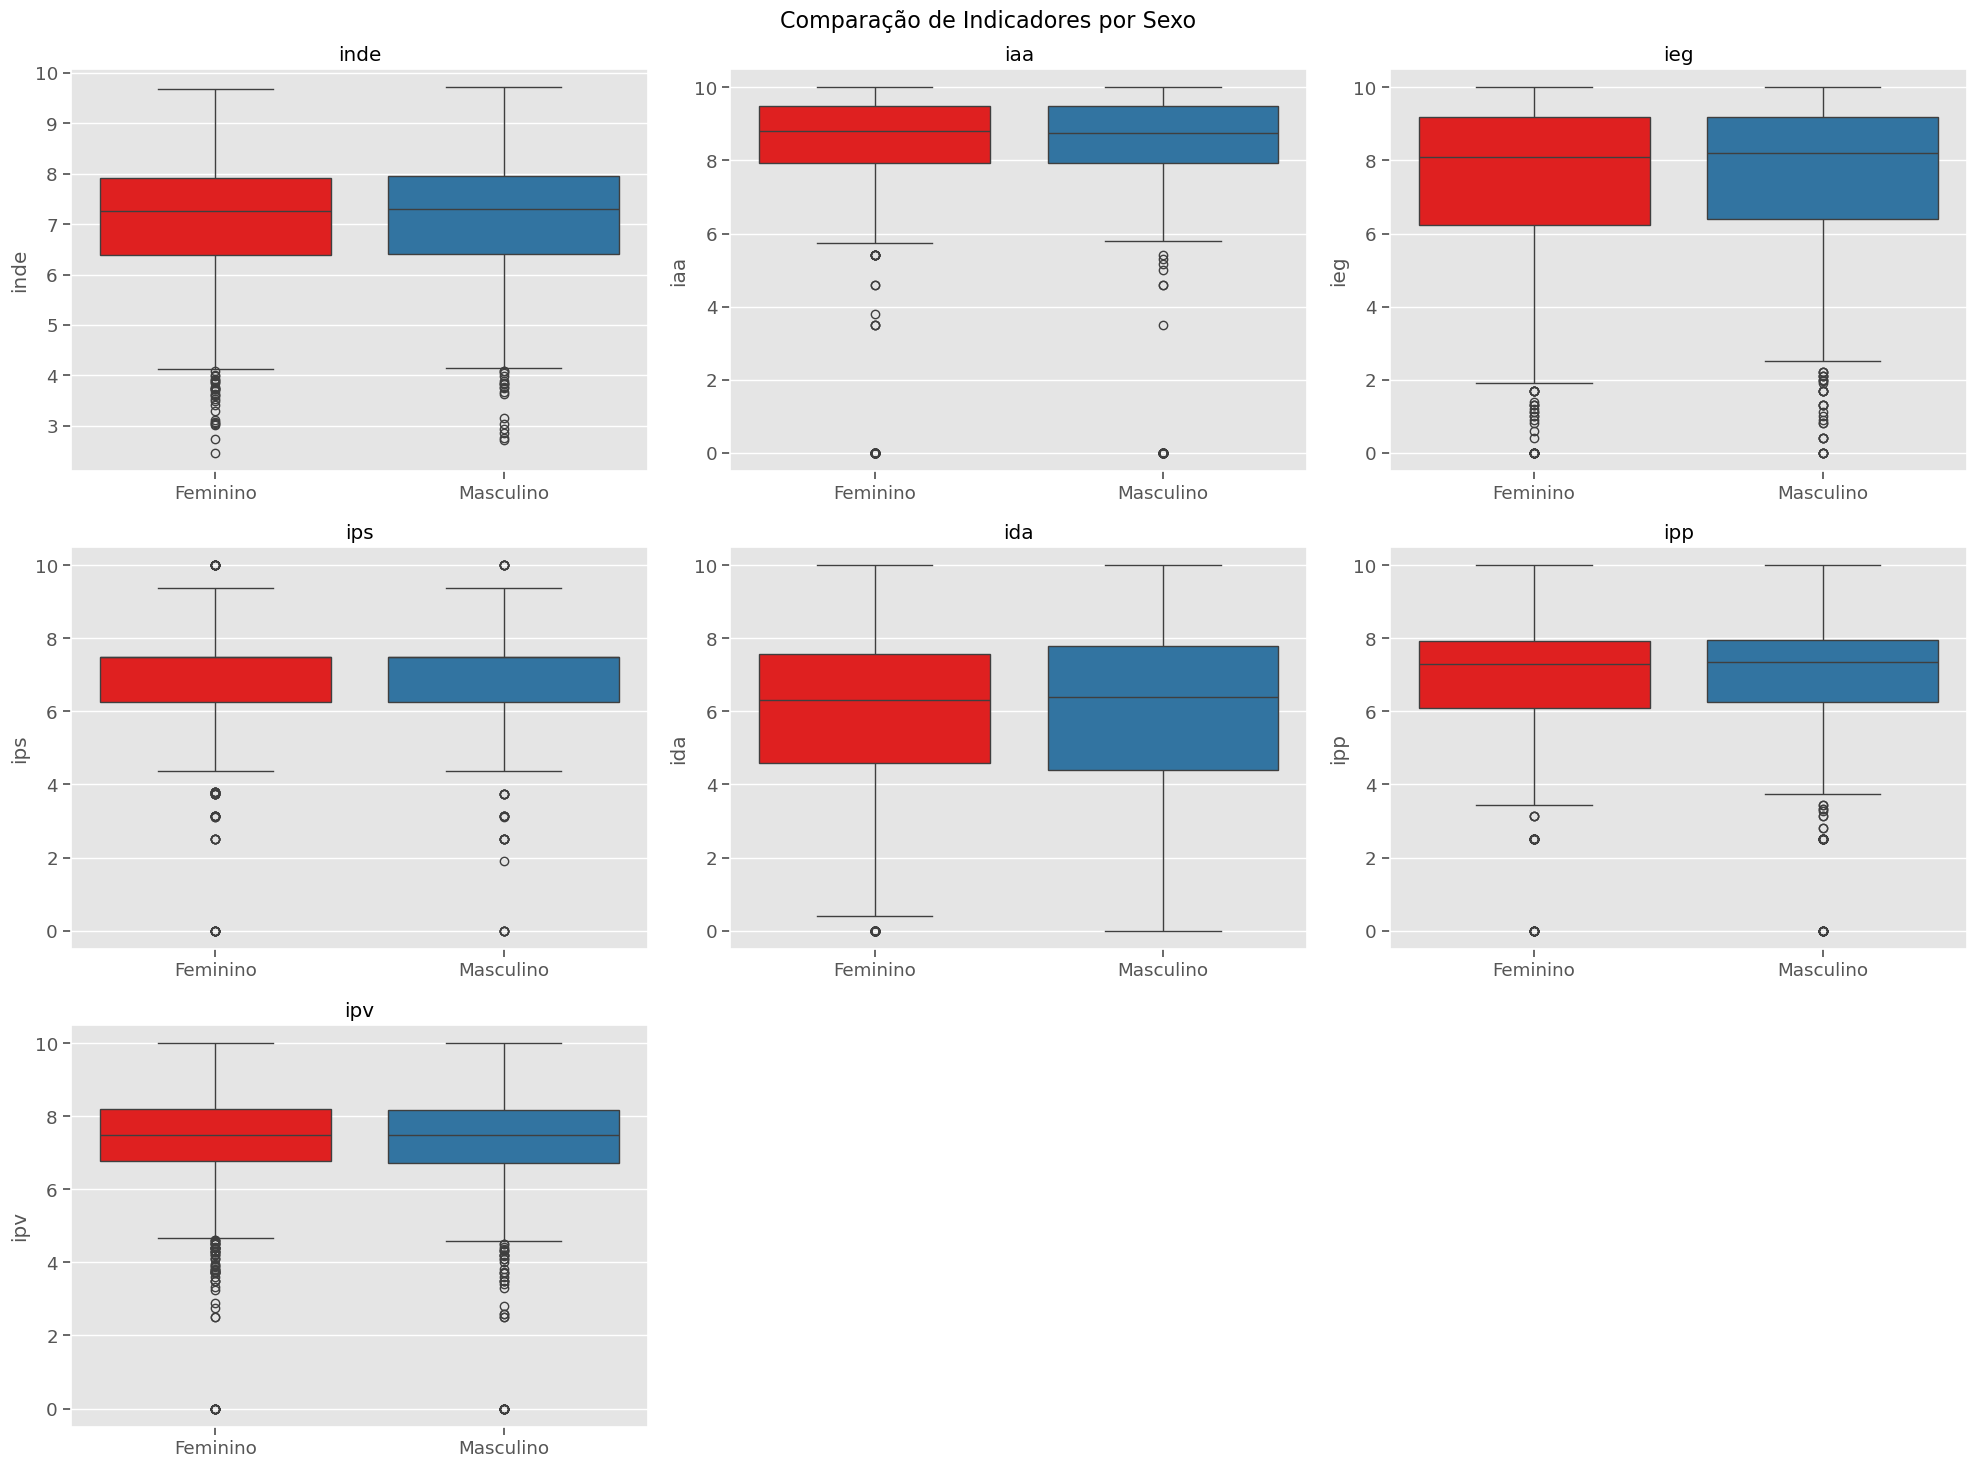

In [195]:
import warnings

warnings.filterwarnings("ignore")

# Filter numeric variables that are present in df_complete
numeric_vars_filtered = [var for var in numeric_vars if var in df_complete.columns]

# Calculate the number of rows and columns for the grid
n_vars = len(numeric_vars_filtered)
n_cols = 3  # You can adjust this to change the number of columns in the grid
n_rows = (n_vars + n_cols - 1) // n_cols

# Create the grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
fig.suptitle("Comparação de Indicadores por Sexo", fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()
# Define colors for each category
colors = ["#FF0000", "#1f77b4"]  # Red for Female, Blue for Male
# Create boxplots for each variable
for i, var in enumerate(numeric_vars_filtered):
    sns.boxplot(x="sexo", y=var, data=df_complete, ax=axes[i], palette=colors)
    axes[i].set_title(var)
    axes[i].set_xlabel("")
    axes[i].set_xticklabels(["Feminino", "Masculino"])

# Remove any unused subplots
for i in range(n_vars, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [196]:
# Lista de indicadores para análise
indicadores = ["inde", "iaa", "ieg", "ips", "ida", "ipp", "ipv"]

# Dicionário para armazenar os resultados
resultados = {}

for indicador in indicadores:
    masculino = df_complete[df_complete["sexo"] == "M"][indicador].dropna()
    feminino = df_complete[df_complete["sexo"] == "F"][indicador].dropna()

    # Aplicando o teste de Mann-Whitney U
    statistic, p_value = stats.mannwhitneyu(
        masculino, feminino, alternative="two-sided"
    )

    resultados[indicador] = {
        "estatistica": statistic,
        "p_valor": p_value,
        "significativo": p_value < 0.05,
    }


# Criando um DataFrame com os resultados para melhor visualização
df_resultados = pd.DataFrame.from_dict(resultados, orient="index")
df_resultados["Indicador"] = df_resultados.index
df_resultados = df_resultados.rename(
    columns={
        "estatistica": "Estatística U",
        "p_valor": "p-valor",
        "significativo": "Diferença Significativa",
    }
)
df_resultados = df_resultados[
    ["Indicador", "Estatística U", "p-valor", "Diferença Significativa"]
]

# Exibindo o DataFrame de resultados
display(df_resultados.style.format({"Estatística U": "{:.4f}", "p-valor": "{:.4f}"}))


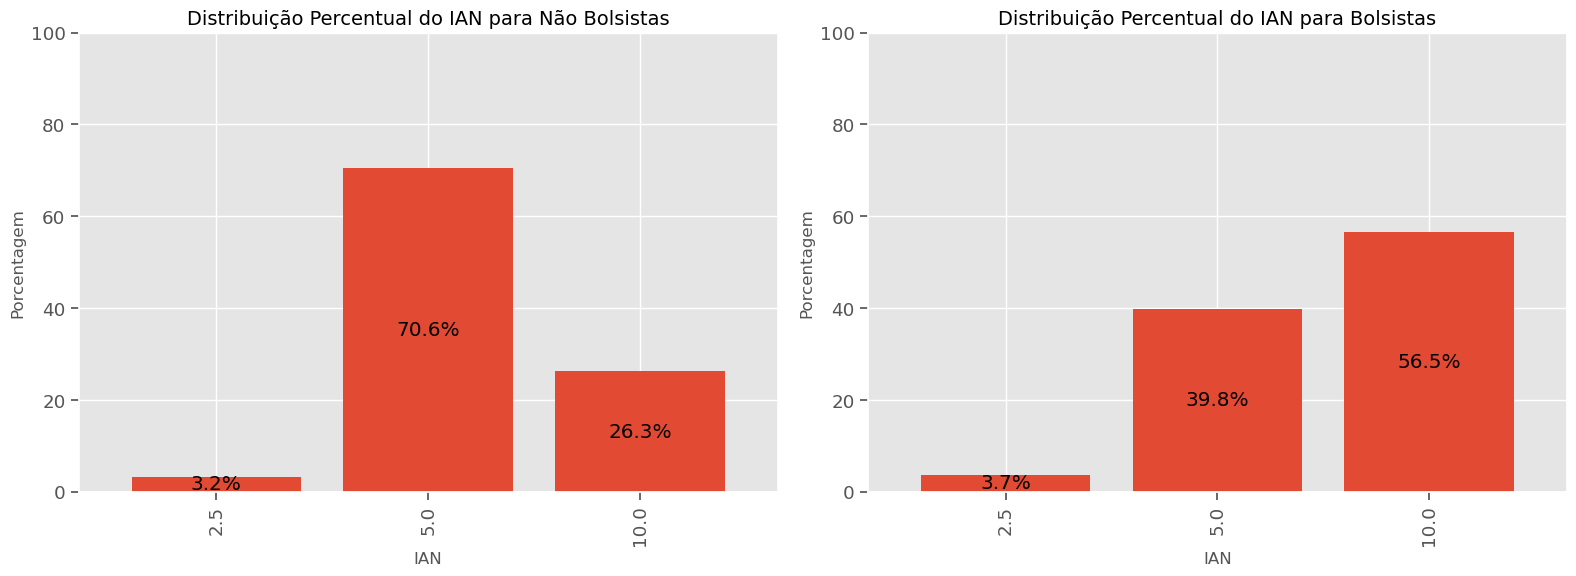

Percentuais para Não Bolsistas:
ian
2.5      3.183024
5.0     70.557029
10.0    26.259947
Name: 0.0, dtype: float64

Percentuais para Bolsistas:
ian
2.5      3.703704
5.0     39.814815
10.0    56.481481
Name: 1.0, dtype: float64


In [197]:
# Preparando os dados
ian_bolsista_data = df_complete[["ian", "bolsista"]].dropna()

# Filtrando apenas os valores de IAN permitidos
ian_bolsista_data = ian_bolsista_data[ian_bolsista_data["ian"].isin([2.5, 5.0, 10.0])]

# Calculando as porcentagens para cada grupo (bolsista e não bolsista)
ian_bolsista_percentages = (
    ian_bolsista_data.groupby("bolsista")["ian"].value_counts(normalize=True).unstack()
    * 100
)

# Criando o gráfico de barras
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ian_bolsista_percentages.loc[0].plot(kind="bar", ax=ax1, width=0.8)
ian_bolsista_percentages.loc[1].plot(kind="bar", ax=ax2, width=0.8)

# Personalizando os gráficos
ax1.set_title("Distribuição Percentual do IAN para Não Bolsistas", fontsize=14)
ax2.set_title("Distribuição Percentual do IAN para Bolsistas", fontsize=14)
for ax in (ax1, ax2):
    ax.set_xlabel("IAN", fontsize=12)
    ax.set_ylabel("Porcentagem", fontsize=12)
    ax.set_ylim(0, 100)

# Adicionando rótulos nas barras
for ax in (ax1, ax2):
    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f%%", label_type="center")

plt.tight_layout()
plt.show()

# Exibindo os percentuais
print("Percentuais para Não Bolsistas:")
print(ian_bolsista_percentages.loc[0])
print("\nPercentuais para Bolsistas:")
print(ian_bolsista_percentages.loc[1])


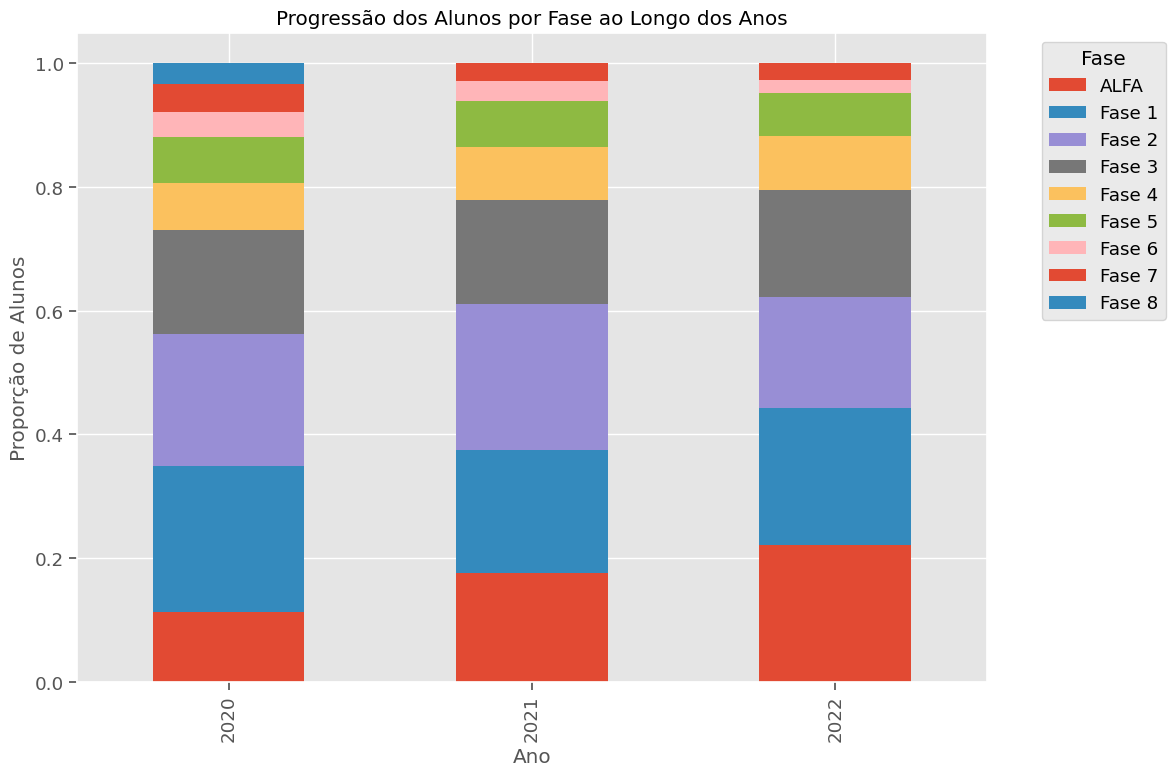

In [198]:
# Análise da progressão dos alunos
progression = df_complete.groupby("ano")["fase"].value_counts(normalize=True).unstack()
progression.plot(kind="bar", stacked=True)
plt.title("Progressão dos Alunos por Fase ao Longo dos Anos")
plt.xlabel("Ano")
plt.ylabel("Proporção de Alunos")
plt.legend(title="Fase", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


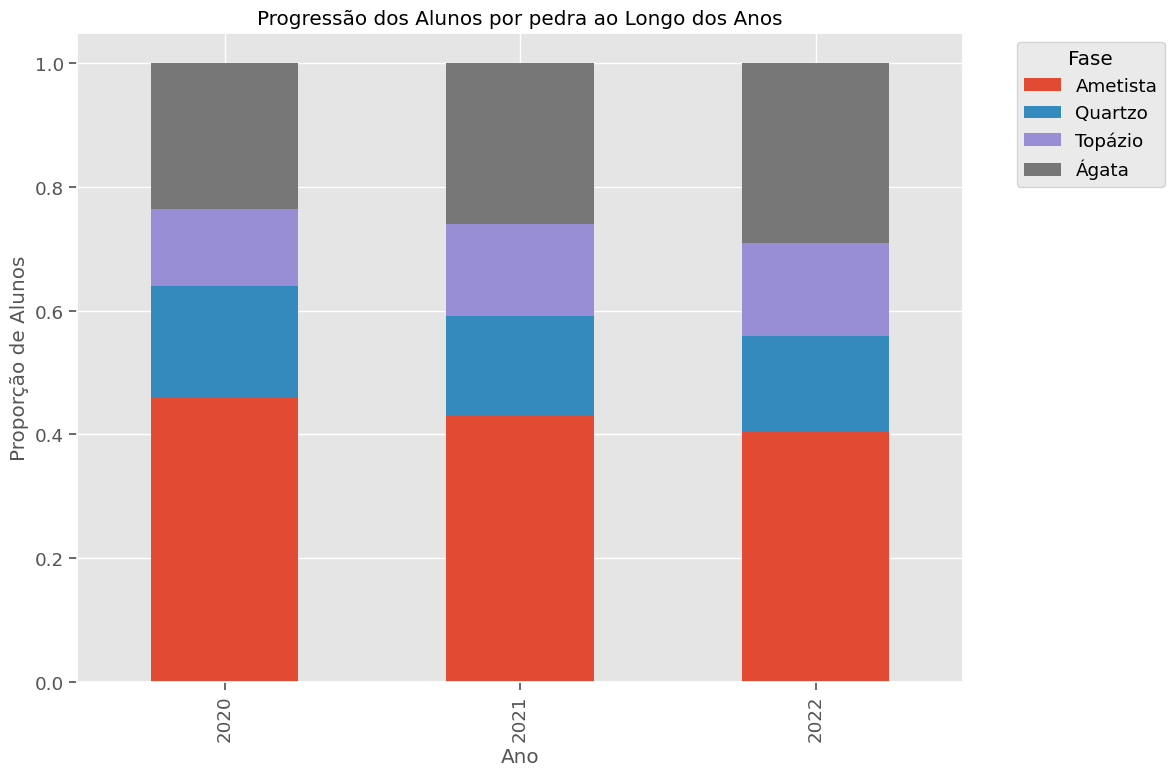

In [199]:
# Análise da progressão dos alunos
progression = df_complete.groupby("ano")["pedra"].value_counts(normalize=True).unstack()
progression.plot(kind="bar", stacked=True)
plt.title("Progressão dos Alunos por pedra ao Longo dos Anos")
plt.xlabel("Ano")
plt.ylabel("Proporção de Alunos")
plt.legend(title="Fase", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [200]:
df_complete.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2273 entries, aluno1_2020 to aluno1349_2022
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   nome                      2273 non-null   object  
 1   sexo                      2270 non-null   object  
 2   cor                       2270 non-null   object  
 3   idtiporesponsavel         2273 non-null   int64   
 4   id                        2273 non-null   int64   
 5   ano                       2273 non-null   int64   
 6   instituicao_ensino_aluno  1411 non-null   object  
 7   idade_aluno               727 non-null    Int64   
 8   anos_pm                   727 non-null    Int64   
 9   ponto_virada              2247 non-null   float64 
 10  inde                      2273 non-null   float64 
 11  pedra                     2273 non-null   category
 12  destaque_ieg              1589 non-null   string  
 13  destaque_ida              1589 no

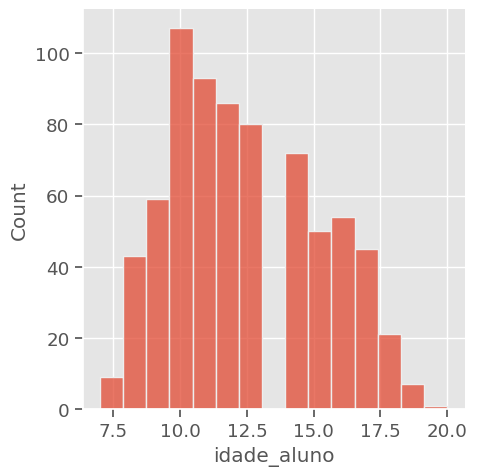

In [201]:
ax = sns.displot(df_complete["idade_aluno"])


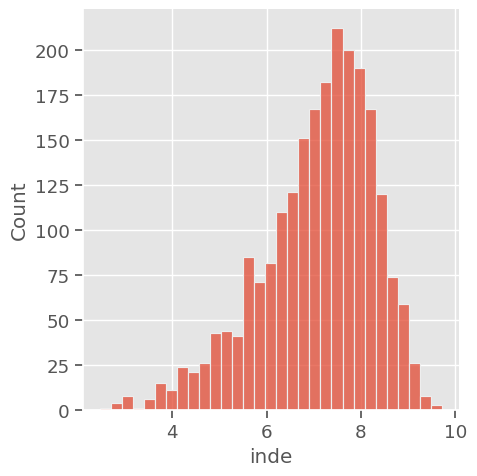

In [202]:
ax = sns.displot(df_complete["inde"])


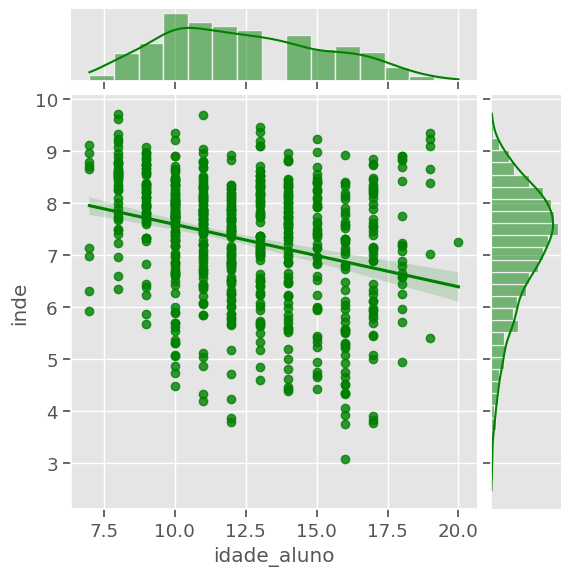

In [203]:
from seaborn import jointplot


new_df = df_cleaned.copy()
jointplot(x="idade_aluno", y="inde", data=new_df, kind="reg", color="green")


# Modelo Preditivo: 

## Random Forest Classifier

### 1. Seleção e pré-processamento de dados

Leitura dos dados empilhados

In [183]:
df_pooled_common = pd.read_csv("data/df_pooled_common.csv").set_index("nome")


In [5]:
print(df_pooled_common.info())


<class 'pandas.core.frame.DataFrame'>
Index: 2251 entries, ALUNO-1 to ALUNO-1349
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ida                   2251 non-null   float64
 1   diff_fase             2249 non-null   float64
 2   ponto_virada_encoded  2251 non-null   int64  
 3   anos_pm               2251 non-null   float64
 4   bolsista_encoded      2251 non-null   int64  
 5   ipv                   2251 non-null   float64
 6   corraca               2248 non-null   object 
 7   ponto_virada          2249 non-null   object 
 8   ian                   2251 non-null   float64
 9   pedra                 2251 non-null   object 
 10  pedra_encoded         2251 non-null   int64  
 11  iaa                   2251 non-null   float64
 12  ips                   2251 non-null   float64
 13  ieg                   2251 non-null   float64
 14  ipp                   2251 non-null   float64
 15  idade         

Seleção das colunas relevantes e tratamento de dados ausentes

In [78]:
selected_columns = [
    "anos_pm",
    # "inde",
    "iaa",
    "ieg",
    "ips",
    "ida",
    "ipp",
    "ipv",
    "ian",
    "bolsista_encoded",
    "ponto_virada_encoded",
    "na_fase",
    "diff_fase",
    "idade",
    "sexo_encoded",
    "ano",
    "pedra",
]

df_model = df_pooled_common[selected_columns].copy().dropna()


In [79]:
from sklearn.preprocessing import LabelEncoder

# codificar a variável alvo pedra
le_pedra = LabelEncoder()
df_model["pedra_encoded"] = le_pedra.fit_transform(df_model["pedra"])


In [80]:
# # concatenate the two dataframes
# df_model = pd.concat(
#     [df_model, pd.get_dummies(df_model["ano"], dtype=int, prefix="d")], axis=1
# ).drop(columns=["ano", "pedra"])
df_model.drop(columns=["pedra"], inplace=True)


In [81]:
df_model.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2246 entries, ALUNO-1 to ALUNO-1349
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   anos_pm               2246 non-null   float64
 1   iaa                   2246 non-null   float64
 2   ieg                   2246 non-null   float64
 3   ips                   2246 non-null   float64
 4   ida                   2246 non-null   float64
 5   ipp                   2246 non-null   float64
 6   ipv                   2246 non-null   float64
 7   ian                   2246 non-null   float64
 8   bolsista_encoded      2246 non-null   int64  
 9   ponto_virada_encoded  2246 non-null   int64  
 10  na_fase               2246 non-null   int64  
 11  diff_fase             2246 non-null   float64
 12  idade                 2246 non-null   float64
 13  sexo_encoded          2246 non-null   float64
 14  ano                   2246 non-null   int64  
 15  pedra_encoded 

Separar os dados em teste e treino

In [82]:
from sklearn.model_selection import train_test_split

X = df_model[df_model.columns.difference(["pedra_encoded"])]
y = df_model["pedra_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


### 2. Treinamento do modelo

a. escoher o modelo

Usaremos o Random Forest Classifier para o nosso modelo preditivo.

In [91]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=180, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=180, random_state=42)

b. avalie a performance do modelo

In [92]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Previsões
y_pred = model.predict(X_test)

# Acurácia
accuracy = accuracy_score(y_test, y_pred)


# Assuming y_test and y_pred are label encoded
le = LabelEncoder()
le.fit(
    df_pooled_common["pedra"].unique()
)  # original_class_names is a list of your class names
classes_ = le.classes_


a. Visualiza a matriz de confusão

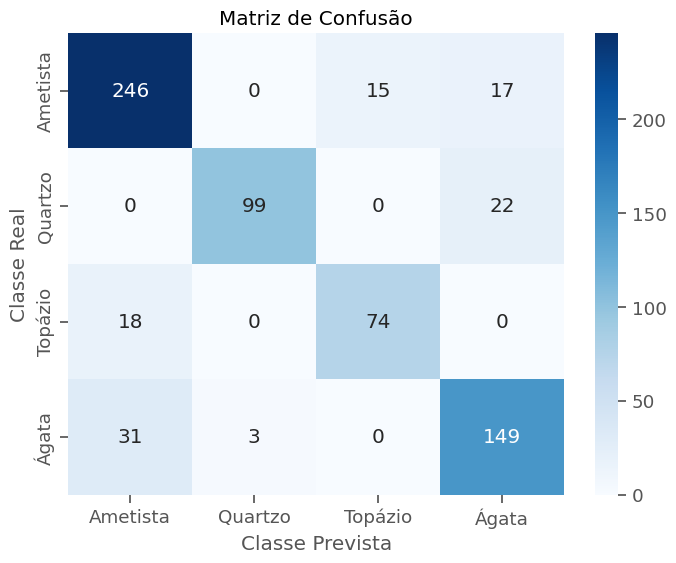

In [93]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes_,
    yticklabels=classes_,
)
plt.title("Matriz de Confusão")
plt.xlabel("Classe Prevista")
plt.ylabel("Classe Real")
plt.show()


b. Mostra a tabela de classificação

In [94]:
# Generate the classification report as a dictionary
class_report_dict = classification_report(
    y_test, y_pred, target_names=classes_, output_dict=True
)

# Convert the dictionary into a DataFrame
class_report_df = pd.DataFrame(class_report_dict).transpose()

# Display the DataFrame
display(class_report_df)


precision    recall  f1-score    support
Ametista       0.833898  0.884892  0.858639  278.00000
Quartzo        0.970588  0.818182  0.887892  121.00000
Topázio        0.831461  0.804348  0.817680   92.00000
Ágata          0.792553  0.814208  0.803235  183.00000
accuracy       0.842730  0.842730  0.842730    0.84273
macro avg      0.857125  0.830407  0.841861  674.00000
weighted avg   0.846879  0.842730  0.843257  674.00000

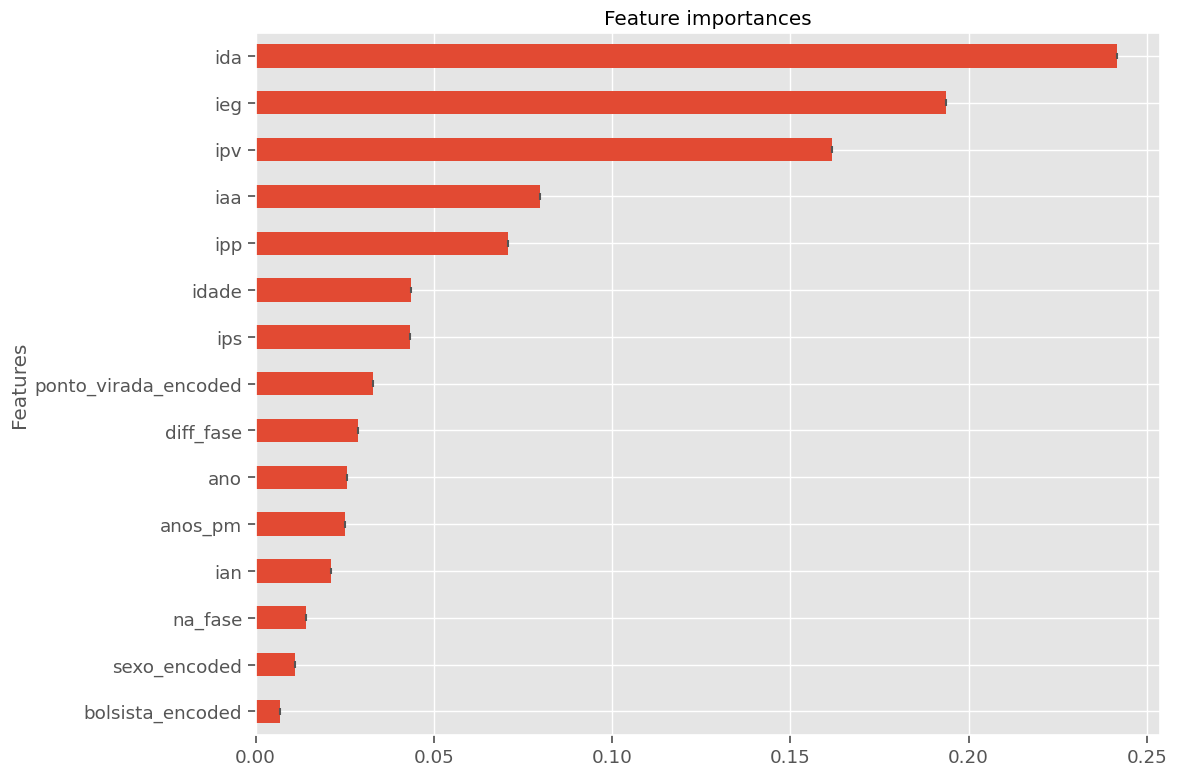

In [164]:
importances = model.feature_importances_
features_names = X.columns
forest_importances = pd.Series(importances, index=features_names).sort_values(
    ascending=True
)
std = forest_importances.std()

fig, ax = plt.subplots()
forest_importances.plot.barh(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Features")
fig.tight_layout()


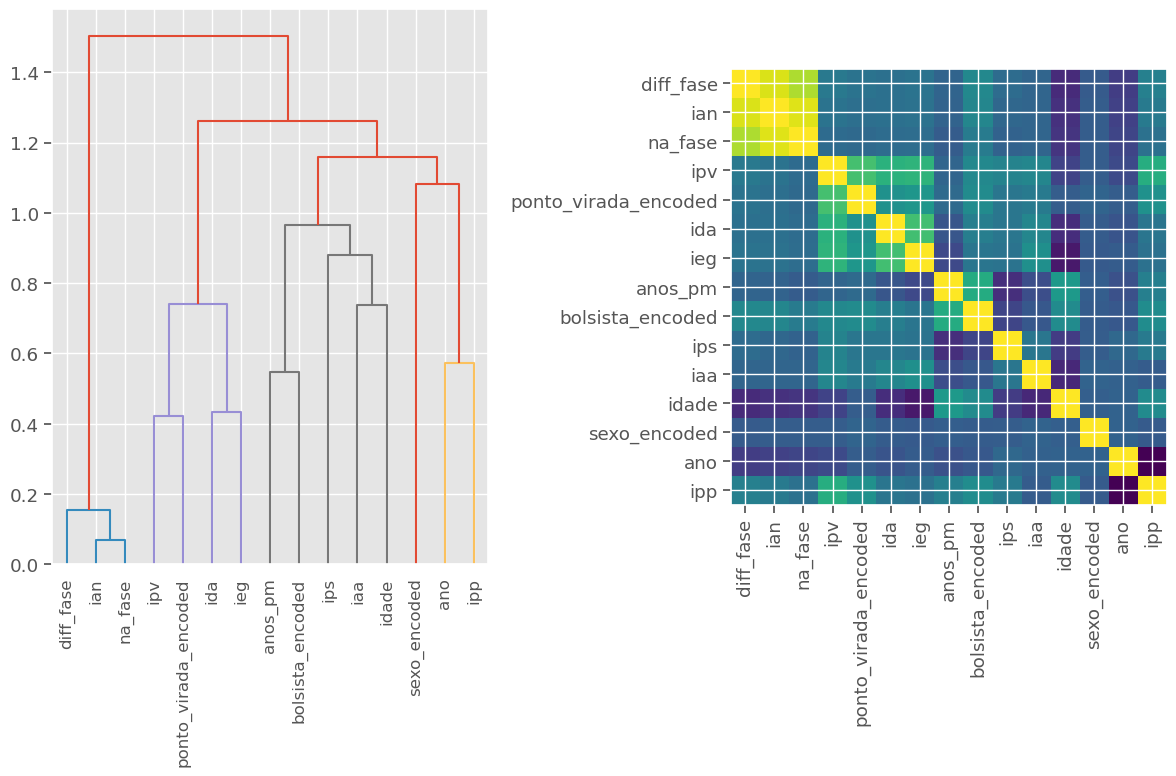

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()


In [ ]:
from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = X.columns[selected_features]

X_train_sel = X_train[selected_features_names]
X_test_sel = X_test[selected_features_names]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print(
    "Baseline accuracy on test data with features removed:"
    f" {clf_sel.score(X_test_sel, y_test):.2}"
)


Baseline accuracy on test data with features removed: 0.62


In [ ]:
import matplotlib
from sklearn.inspection import permutation_importance
from sklearn.utils.fixes import parse_version


def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    # `labels` argument in boxplot is deprecated in matplotlib 3.9 and has been
    # renamed to `tick_labels`. The following code handles this, but as a
    # scikit-learn user you probably can write simpler code by using `labels=...`
    # (matplotlib < 3.9) or `tick_labels=...` (matplotlib >= 3.9).
    tick_labels_parameter_name = (
        "tick_labels"
        if parse_version(matplotlib.__version__) >= parse_version("3.9")
        else "labels"
    )
    tick_labels_dict = {tick_labels_parameter_name: X.columns[perm_sorted_idx]}
    ax.boxplot(result.importances[perm_sorted_idx].T, vert=False, **tick_labels_dict)
    ax.axvline(x=0, color="k", linestyle="--")
    return ax


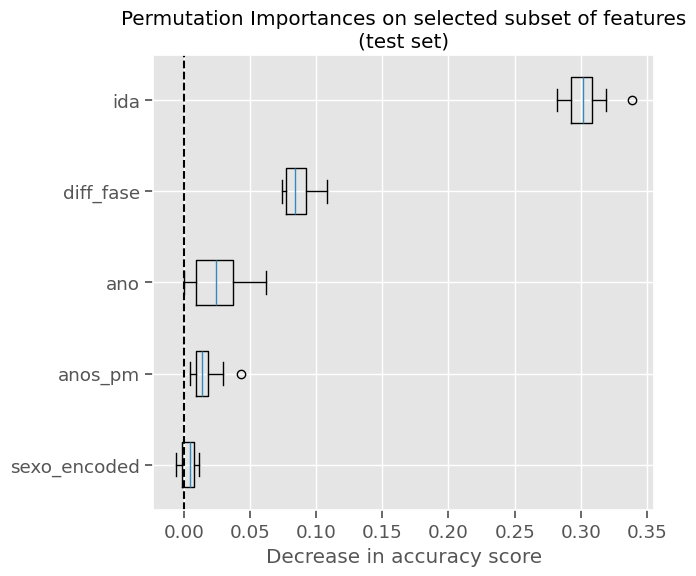

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(clf_sel, X_test_sel, y_test, ax)
ax.set_title("Permutation Importances on selected subset of features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.show()


## Xgboost Classifier

In [7]:
def display_scores(scores):
    print(
        "Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(
            scores, np.mean(scores), np.std(scores)
        )
    )


In [8]:
def report_best_scores(results, n_top=3):
    best_params = []
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")
            best_params.append(results["params"][candidate])
    return best_params


In [112]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    objective="multi:softprob",
    random_state=42,
    device="cuda",
    tree_method="gpu_hist",
    n_estimators=100,
)
# Fit the model, test sets are used for early stopping.
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])


[0]	validation_0-mlogloss:1.10542
[1]	validation_0-mlogloss:0.93325
[2]	validation_0-mlogloss:0.80918
[3]	validation_0-mlogloss:0.72148
[4]	validation_0-mlogloss:0.65699
[5]	validation_0-mlogloss:0.60389
[6]	validation_0-mlogloss:0.55914
[7]	validation_0-mlogloss:0.52501
[8]	validation_0-mlogloss:0.49653
[9]	validation_0-mlogloss:0.47420
[10]	validation_0-mlogloss:0.45508
[11]	validation_0-mlogloss:0.43927
[12]	validation_0-mlogloss:0.42642
[13]	validation_0-mlogloss:0.41455
[14]	validation_0-mlogloss:0.40736
[15]	validation_0-mlogloss:0.39702
[16]	validation_0-mlogloss:0.39263
[17]	validation_0-mlogloss:0.38627
[18]	validation_0-mlogloss:0.37838
[19]	validation_0-mlogloss:0.37699
[20]	validation_0-mlogloss:0.37158
[21]	validation_0-mlogloss:0.36875
[22]	validation_0-mlogloss:0.36354
[23]	validation_0-mlogloss:0.36025
[24]	validation_0-mlogloss:0.35893
[25]	validation_0-mlogloss:0.35734
[26]	validation_0-mlogloss:0.35641
[27]	validation_0-mlogloss:0.35427
[28]	validation_0-mlogloss:0.3

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [117]:
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    train_test_split,
)
from scipy.stats import uniform, randint

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3),  # default 0.1
    "max_depth": randint(2, 6),  # default 3
    "n_estimators": randint(100, 150),  # default 100
    "subsample": uniform(0.6, 0.4),
}


search = RandomizedSearchCV(
    xgb_model,
    param_distributions=params,
    random_state=42,
    n_iter=100,
    cv=3,
    verbose=1,
    n_jobs=1,
    return_train_score=True,
)

search.fit(X, y)

best_params = report_best_scores(search.cv_results_, 1)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Model with rank: 1
Mean validation score: 0.799 (std: 0.053)
Parameters: {'colsample_bytree': 0.7415059277253404, 'gamma': 0.0663727111214849, 'learning_rate': 0.32086106013424764, 'max_depth': 3, 'n_estimators': 129, 'subsample': 0.6164270067071503}



In [180]:
# modelo com os hiperparâmetros ajustados
params = {
    "objective": "multi:softprob",
    "random_state": 42,
    "tree_method": "hist",
}

params.update(best_params[0])

xgb_model = xgb.XGBClassifier(**params)
# Fit the model, test sets are used for early stopping.
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7415059277253404, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.0663727111214849,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.32086106013424764,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=129, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [147]:
y_pred = xgb_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

print(conf_matrix)

print(classification_report(y_test, y_pred))


[[249   0  15  14]
 [  0 108   0  13]
 [ 14   0  78   0]
 [ 23   2   0 158]]
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       278
           1       0.98      0.89      0.94       121
           2       0.84      0.85      0.84        92
           3       0.85      0.86      0.86       183

    accuracy                           0.88       674
   macro avg       0.89      0.87      0.88       674
weighted avg       0.88      0.88      0.88       674



In [148]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(xgb_model, X_train, y_train, scoring="accuracy", cv=5)

display(scores)


array([0.88571429, 0.9015873 , 0.89171975, 0.89490446, 0.89490446])

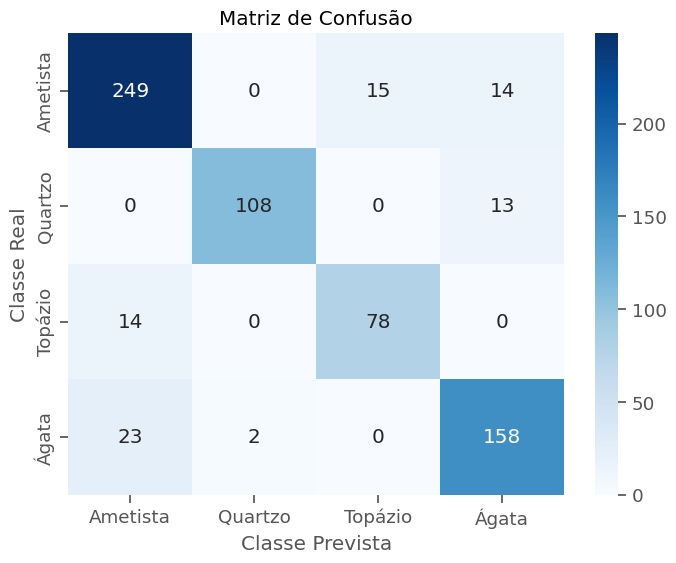

In [149]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes_,
    yticklabels=classes_,
)
plt.title("Matriz de Confusão")
plt.xlabel("Classe Prevista")
plt.ylabel("Classe Real")
plt.show()


In [150]:
# Generate the classification report as a dictionary
class_report_dict = classification_report(
    y_test, y_pred, target_names=classes_, output_dict=True
)

# Convert the dictionary into a DataFrame
class_report_df = pd.DataFrame(class_report_dict).transpose()

# Display the DataFrame
display(class_report_df)


precision    recall  f1-score     support
Ametista       0.870629  0.895683  0.882979  278.000000
Quartzo        0.981818  0.892562  0.935065  121.000000
Topázio        0.838710  0.847826  0.843243   92.000000
Ágata          0.854054  0.863388  0.858696  183.000000
accuracy       0.879822  0.879822  0.879822    0.879822
macro avg      0.886303  0.874865  0.879996  674.000000
weighted avg   0.881733  0.879822  0.880312  674.000000

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

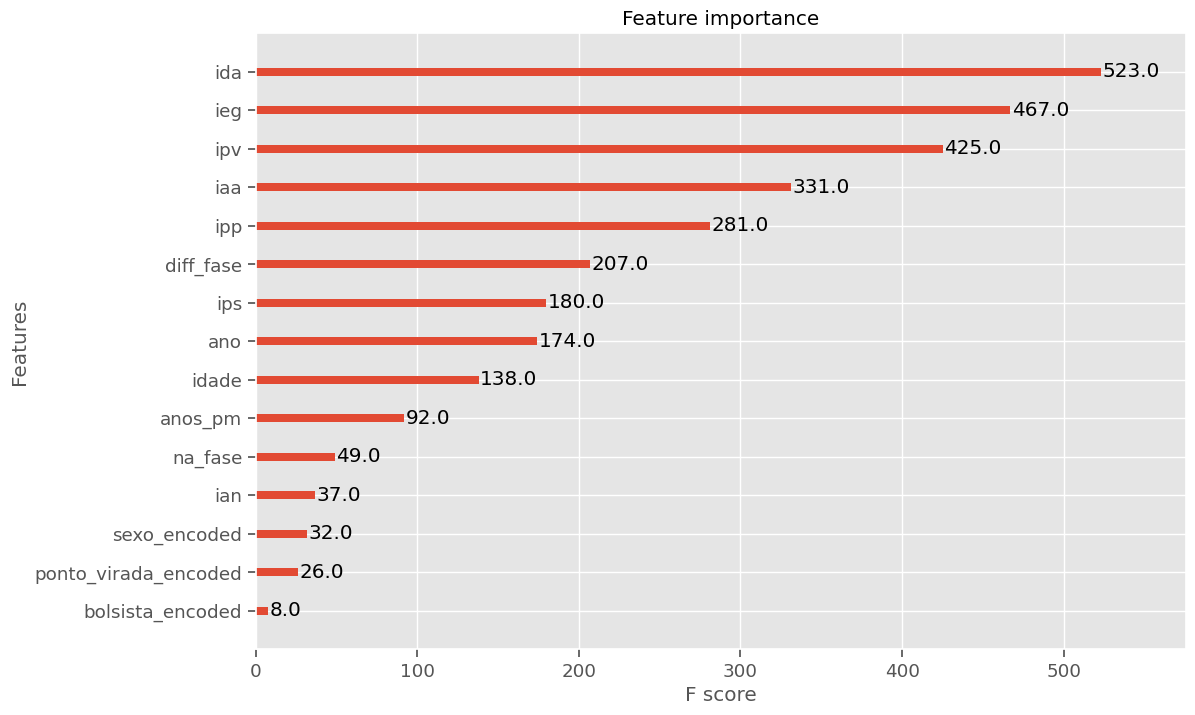

In [151]:
xgb.plot_importance(xgb_model)


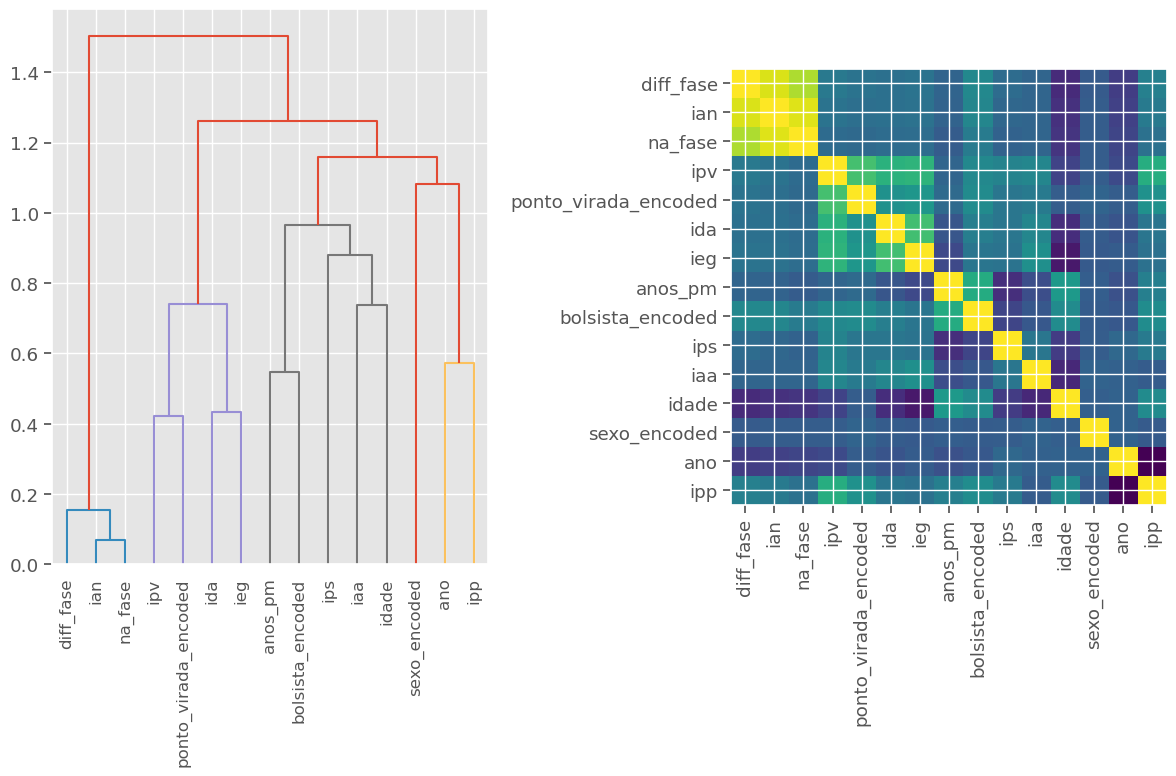

In [175]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()


In [182]:
from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = X.columns[selected_features]

X_train_sel = X_train[selected_features_names]
X_test_sel = X_test[selected_features_names]

clf_sel = xgb.XGBClassifier(**params)
clf_sel.fit(X_train_sel, y_train)
print(
    "Baseline accuracy on test data with features removed:"
    f" {clf_sel.score(X_test_sel, y_test):.2}"
)


print(
    "Baseline accuracy on test data without features removed:"
    f" {xgb_model.score(X_test, y_test):.2}"
)


Baseline accuracy on test data with features removed: 0.66
Baseline accuracy on test data without features removed: 0.88


In [178]:
import matplotlib
from sklearn.inspection import permutation_importance
from sklearn.utils.fixes import parse_version


def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    # `labels` argument in boxplot is deprecated in matplotlib 3.9 and has been
    # renamed to `tick_labels`. The following code handles this, but as a
    # scikit-learn user you probably can write simpler code by using `labels=...`
    # (matplotlib < 3.9) or `tick_labels=...` (matplotlib >= 3.9).
    tick_labels_parameter_name = (
        "tick_labels"
        if parse_version(matplotlib.__version__) >= parse_version("3.9")
        else "labels"
    )
    tick_labels_dict = {tick_labels_parameter_name: X.columns[perm_sorted_idx]}
    ax.boxplot(result.importances[perm_sorted_idx].T, vert=False, **tick_labels_dict)
    ax.axvline(x=0, color="k", linestyle="--")
    return ax


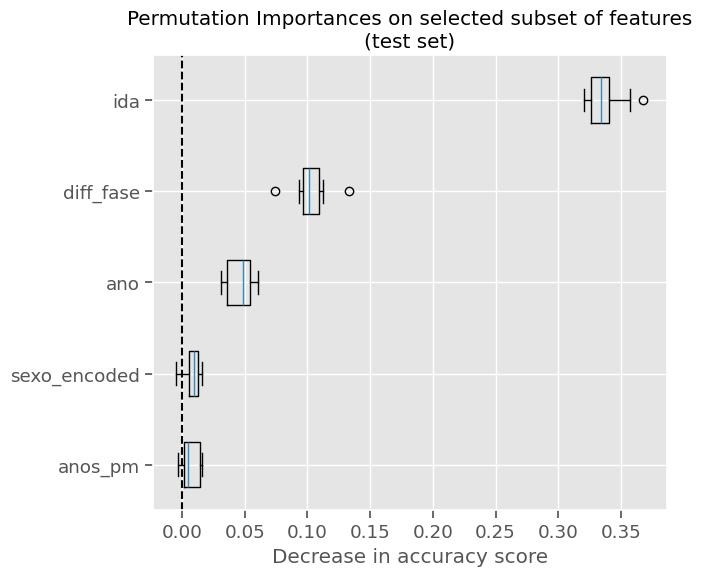

In [179]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(clf_sel, X_test_sel, y_test, ax)
ax.set_title("Permutation Importances on selected subset of features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.show()


## XGBoost - Previsão para posição no ranking geral

In [9]:
df_pooled_ranking = pd.read_csv("data/df_pooled_ranking.csv").set_index("nome")
df_pooled_ranking.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1646 entries, ALUNO-2 to ALUNO-1349
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ida                   1646 non-null   float64
 1   diff_fase             1646 non-null   float64
 2   ponto_virada_encoded  1646 non-null   int64  
 3   anos_pm               1646 non-null   float64
 4   bolsista_encoded      1646 non-null   int64  
 5   ipv                   1646 non-null   float64
 6   corraca               1646 non-null   object 
 7   ponto_virada          1646 non-null   object 
 8   ian                   1646 non-null   float64
 9   pedra                 1646 non-null   object 
 10  pedra_encoded         1646 non-null   int64  
 11  iaa                   1646 non-null   float64
 12  ips                   1646 non-null   float64
 13  ieg                   1646 non-null   float64
 14  ipp                   1646 non-null   float64
 15  idade         

<Axes: >

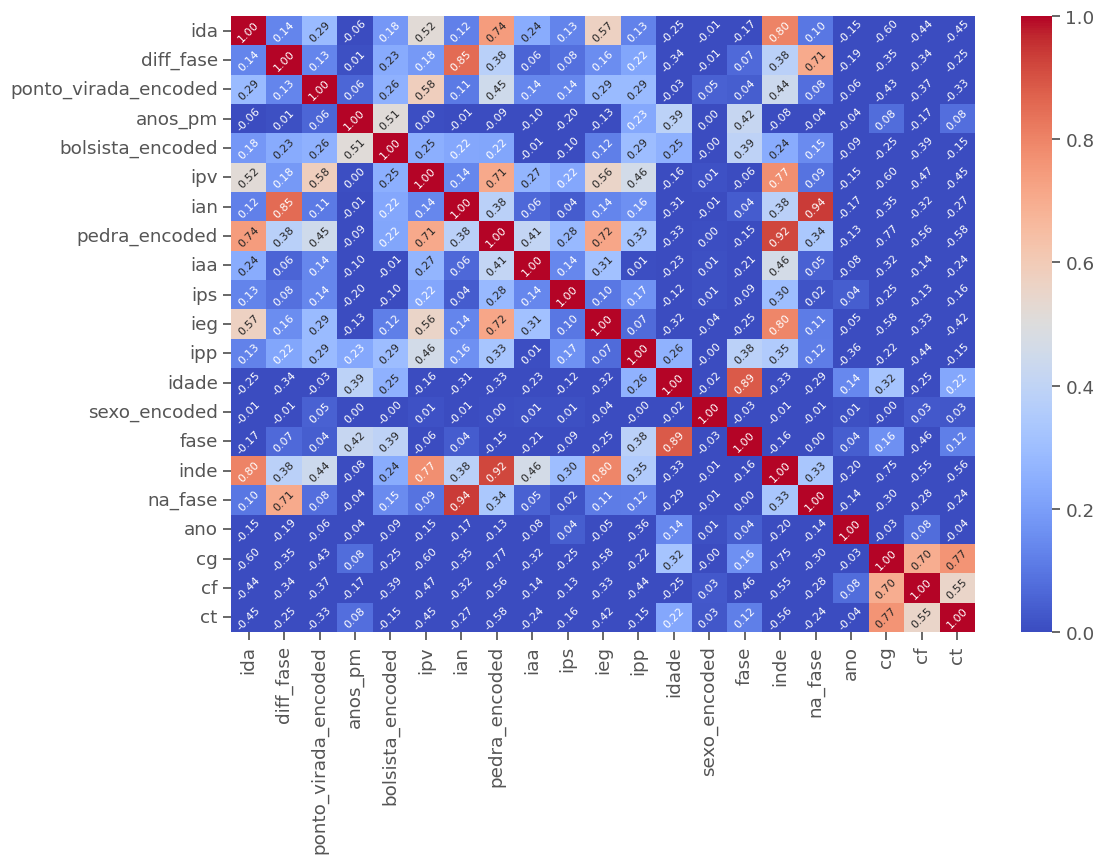

In [13]:
corr_matrix = df_pooled_ranking.drop(
    columns=["pedra", "corraca", "sexo", "ponto_virada"]
).corr()

# heatmap
sns.heatmap(
    corr_matrix,
    annot=True,
    vmin=0.0,
    vmax=1.0,
    cmap="coolwarm",
    fmt=".2f",
    annot_kws={"size": 8, "rotation": 45},
)


<Axes: xlabel='cg', ylabel='inde'>

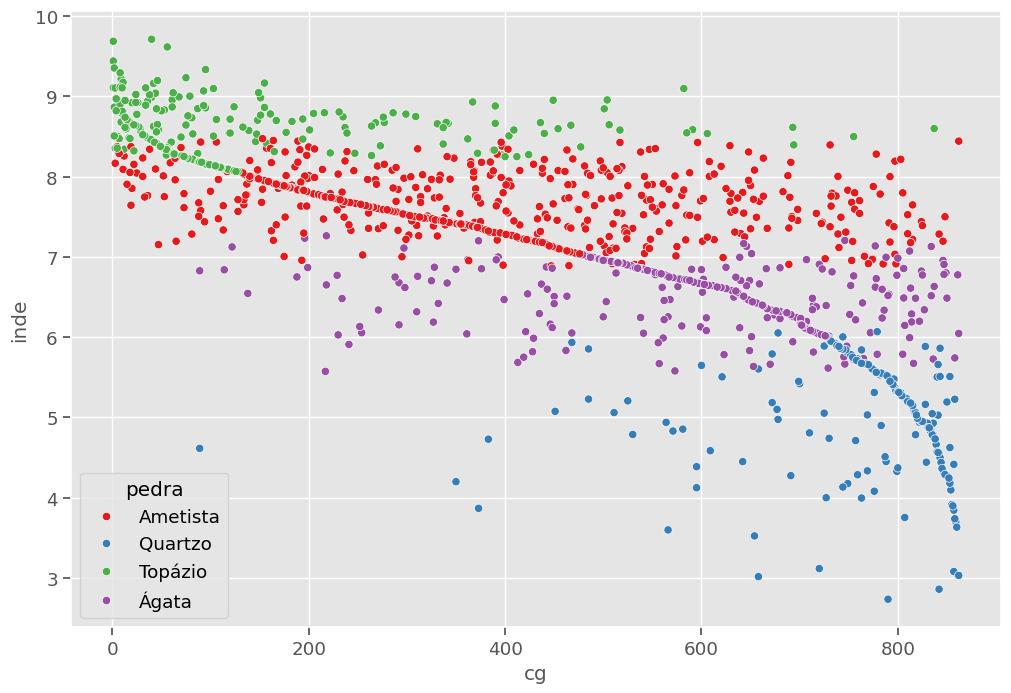

In [15]:
sns.scatterplot(data=df_pooled_ranking, x="cg", y="inde", hue="pedra", palette="Set1")


<Axes: xlabel='idade', ylabel='Density'>

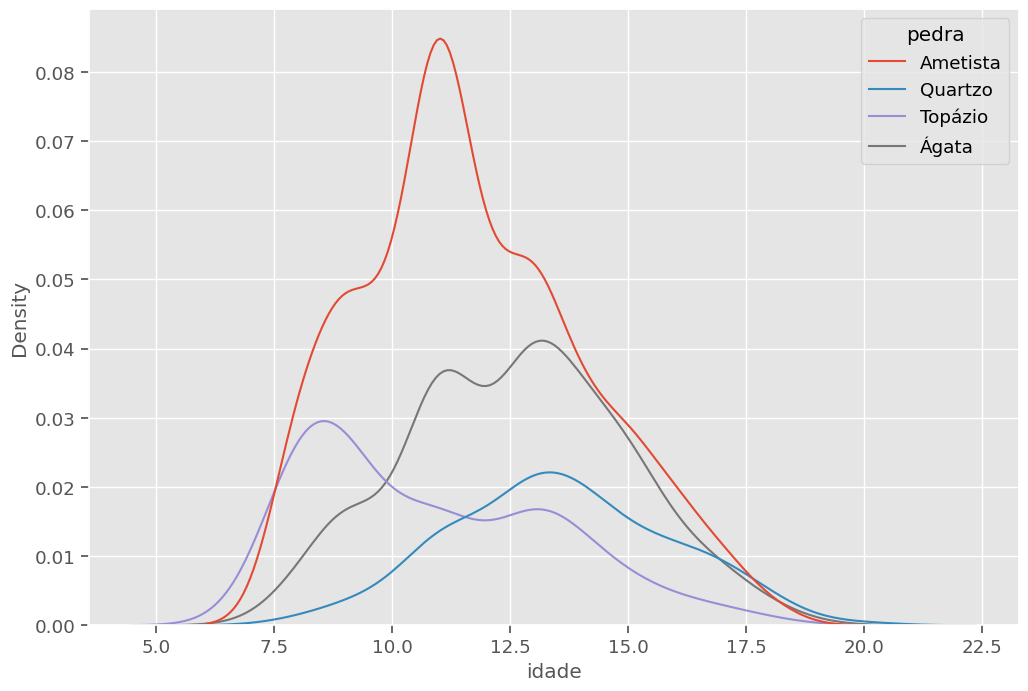

In [18]:
sns.kdeplot(data=df_pooled_ranking, x="idade", hue="pedra")


In [21]:
df_pooled_ranking.columns


Index(['ida', 'diff_fase', 'ponto_virada_encoded', 'anos_pm',
       'bolsista_encoded', 'ipv', 'corraca', 'ponto_virada', 'ian', 'pedra',
       'pedra_encoded', 'iaa', 'ips', 'ieg', 'ipp', 'idade', 'sexo_encoded',
       'fase', 'inde', 'sexo', 'na_fase', 'ano', 'cg', 'cf', 'ct'],
      dtype='object')

In [32]:
features_cols = df_pooled_ranking.columns.difference(
    ["corraca", "ponto_virada", "pedra", "pedra_encoded", "sexo", "cf", "ct", "fase"]
)


In [33]:
def data_prepare(df, target, test_size=0.3):
    X = df[df.columns.difference([target])]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )
    return X_train, X_test, y_train, y_test


In [49]:
df_model = df_pooled_ranking[features_cols]

X_train, X_test, y_train, y_test = data_prepare(df_model, "cg", 0.2)


In [50]:
X_train.columns


Index(['ano', 'anos_pm', 'bolsista_encoded', 'diff_fase', 'iaa', 'ian', 'ida',
       'idade', 'ieg', 'inde', 'ipp', 'ips', 'ipv', 'na_fase',
       'ponto_virada_encoded', 'sexo_encoded'],
      dtype='object')

In [93]:
from email import iterators
import xgboost as xgb

xgb_model_reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    device="cuda",
    tree_method="gpu_hist",
    predictor="gpu_predictor",
    iterations=1000,
)
# Fit the model, test sets are used for early stopping.
xgb_model_reg.fit(X_train, y_train, eval_set=[(X_test, y_test)])


[0]	validation_0-rmse:202.08899
[1]	validation_0-rmse:173.94581
[2]	validation_0-rmse:159.14223
[3]	validation_0-rmse:152.39409
[4]	validation_0-rmse:147.76556
[5]	validation_0-rmse:147.48772
[6]	validation_0-rmse:146.06512
[7]	validation_0-rmse:145.96247
[8]	validation_0-rmse:145.61298
[9]	validation_0-rmse:146.15974
[10]	validation_0-rmse:146.46999
[11]	validation_0-rmse:146.65000
[12]	validation_0-rmse:147.07651
[13]	validation_0-rmse:147.80595
[14]	validation_0-rmse:147.77682
[15]	validation_0-rmse:147.76070
[16]	validation_0-rmse:147.33911
[17]	validation_0-rmse:147.28507
[18]	validation_0-rmse:147.45533
[19]	validation_0-rmse:147.39897
[20]	validation_0-rmse:147.57790
[21]	validation_0-rmse:147.52884
[22]	validation_0-rmse:147.55221
[23]	validation_0-rmse:147.56341
[24]	validation_0-rmse:147.39774
[25]	validation_0-rmse:147.32279
[26]	validation_0-rmse:147.32923
[27]	validation_0-rmse:148.37761
[28]	validation_0-rmse:148.31520
[29]	validation_0-rmse:148.75574
[30]	validation_0-rm

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, iterations=1000, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, ...)

In [102]:
df_model.columns


Index(['ano', 'anos_pm', 'bolsista_encoded', 'cg', 'diff_fase', 'iaa', 'ian',
       'ida', 'idade', 'ieg', 'inde', 'ipp', 'ips', 'ipv', 'na_fase',
       'ponto_virada_encoded', 'sexo_encoded'],
      dtype='object')

In [111]:
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


data = df_model.copy()

# Aplicar o Quantile Binning com 6 categorias para a variável 'cg'
kbins = KBinsDiscretizer(n_bins=6, encode="ordinal", strategy="quantile")
data["cg_category_encoded"] = kbins.fit_transform(data[["cg"]])

# Selecionar as variáveis preditoras e a nova variável alvo
X = data.drop(
    columns=["cg", "cg_category_encoded"]
)  # Remover as colunas não necessárias
y = data["cg_category_encoded"]  # A variável alvo agora é a codificada

# Dividir os dados em treino e teste (80% treino e 20% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Aplicar normalização (opcional para XGBoost)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Criar e treinar o modelo XGBoost
xgb_model = XGBClassifier(
    objective="multi:softmax",  # Para múltiplas classes
    num_class=6,  # Número de classes
    learning_rate=0.0001,
    max_depth=7,
    n_estimators=150,
    use_label_encoder=False,
    eval_metric="mlogloss",  # Log loss para múltiplas classes
    device="cuda",
    tree_method="gpu_hist",
    predictor="gpu_predictor",
    colsample_bytree=0.8,
    gamma=0.1,
    reg_lambda=1,
    min_child_weight=1,
)

xgb_model.fit(X_train_scaled, y_train)

# Prever os resultados no conjunto de teste
y_pred = xgb_model.predict(X_test_scaled)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)

print(f"Acurácia no teste: {accuracy}")


Acurácia no teste: 0.6606060606060606


In [104]:
from matplotlib.pyplot import grid
from sklearn.model_selection import RandomizedSearchCV

# Criar e treinar o modelo XGBoost
xgb_model = XGBClassifier(
    objective="multi:softmax",  # Para múltiplas classes
    num_class=6,  # Número de classes
    use_label_encoder=False,
    eval_metric="mlogloss",  # Log loss para múltiplas classes
    device="cuda",
    tree_method="gpu_hist",
    predictor="gpu_predictor",
)

param_grid = {
    "n_estimators": [500, 1000],
    "max_depth": [5, 7, 9],
    "learning_rate": [0.005, 0.05],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.1, 0.2],
    "reg_alpha": [0, 0.01, 0.1],
    "reg_lambda": [1, 1.5],
    "min_child_weight": [1, 3],
}


grid_search = RandomizedSearchCV(
    xgb_model_reg,
    param_distributions=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    verbose=1,
    n_iter=100,
)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [ ]:
print("Melhores hiperparâmetros encontrados:")
print(grid_search.best_params_)

best_params = grid_search.best_params_

xgb_best = xgb.XGBRegressor(
    objective="reg:squarederror",
    tree_method="gpu_hist",
    predictor="gpu_predictor",
    random_state=42,
    **best_params
)

xgb_best.fit(X_train, y_train)


In [ ]:
y_pred = xgb_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE nos dados de teste: {mse}")


In [ ]:
xgb.plot_importance(xgb_best)
plt.show()


In [80]:
scores = cross_val_score(
    xgb_model_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=5
)

display_scores(np.sqrt(-scores))


Scores: [137.93284872 133.95512923 140.61644906 119.63263283 145.48045187]
Mean: 135.524
Std: 8.785


In [88]:
y_pred = xgb_model_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(np.sqrt(mse))


139.23610752064656


In [89]:
xgb_model_reg.score(X_train, y_train)


0.7910757018015905

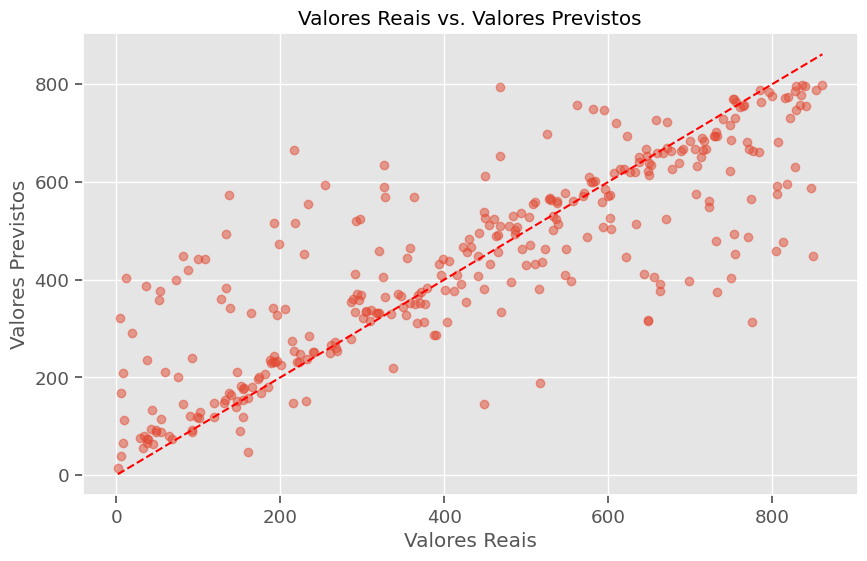

In [92]:
# Plotando Valores Reais vs Previstos
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred, fit_reg=False, scatter_kws={"alpha": 0.5})
plt.xlabel("Valores Reais")
plt.ylabel("Valores Previstos")
plt.title("Valores Reais vs. Valores Previstos")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.show()


In [85]:
df = pd.DataFrame({"y_pred": y_pred, "y_test": y_test})
df


y_pred  y_test
nome                          
ALUNO-560   590.792175   806.0
ALUNO-1271  371.153198   343.0
ALUNO-591   118.770538    98.0
ALUNO-930   321.443665     5.0
ALUNO-1029   47.627777   161.0
...                ...     ...
ALUNO-247   662.359314   688.0
ALUNO-152   259.487061   268.0
ALUNO-251   342.400940   139.0
ALUNO-477   721.687866   672.0
ALUNO-51    470.207214   504.0

[330 rows x 2 columns]